In [1]:
from preprocessing.load import loaddata, to_pandas

import time
import csv
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import pickle 
import graphviz 
from IPython.display import Image, display

from sktime.classification.interval_based import CanonicalIntervalForest
from sktime.transformations.panel.catch22 import Catch22
from sktime.classification.interval_based import DrCIF
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier as sktime_KneighborsClassifier
from sktime.distances import dtw_distance

from tslearn.metrics import dtw
from tslearn.neighbors import KNeighborsTimeSeriesClassifier as tslearn_KNeighborsClassifier

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Dokumentation

Im Allgemeinen betrachten wir mehrdimensionale Zeitreihen, die für jeden Zeitpunkt verschiedene Messungen festhalten. <br>
In diesem Anwendungsbeispiel haben wir Daten von einer Maschine, die Messer herstellt. Die Variablen werden einmal pro Millisekunde gemessen. Mithilfe von Expertenwissen, haben wir bereits 16 Messgrößen identifiziert, die besonders wichtig sind und wir beschränken uns auf diese.  <br> 
Jeder Produktionsvorgang besteht aus den Phasen Vorschleifen, Zahnen und Nachschleifen. Im Folgenden bezeichnen wir diese Phasentypen mit den Variablen `c1`, `c2`, `c3`. <br>
Ziel ist es, einen beliebigen Ausschnitt des Produktionsvorganges durch diese Phasen klassifizieren zu können. 

In [2]:
chans = ['MV_n', 'MV_M','OSM_n','OSM_M','USM_n','USM_M','OSZ_n', 'OSZ_M','USZ_n', 'USZ_M','TS_n','TS_M','TSZ_n','TSZ_M', 'OA_n', 'OA_M'] # relevante Messgrößen
c1 = 'BP_auto_vorschleifen_aktiv'
c2 = 'BP_auto_zahnen_aktiv' 
c3 = 'BP_auto_nachschleifen_aktiv'
classes = [c1,c2,c3]
names = ["None", "Vorschleifen", "Zahnen","Nachschleifen"]

Wir haben die folgenden Methoden für die Klassifizierung untersucht: 
- Canonical Interval Forest (CIF)
- Euclidean Nearest Neighbor (Euclidean NN)
- Dependent Dynamic Timewarping Nearest Neighbor (D_DTW NN)
- Random Convolutional Kernel Transform (ROCKET)

In dem zweiten Abschnitt wenden wir diese Methoden auf die Beispieldaten an und geben Details zu ihrer Funktionsweise. 

Es können zwei Möglichkeiten unterschieden werden, wie die Ausschnitte, die klassifiziert werden sollen, gebildet werden:
1. Wir nehmen an, dass bekannt ist, wann die verschiedenen Phasen je Produktionsvorgang anfangen und enden. Eine einzelne Phase eines Produktionsvorgangs nennen wir ein Segment. Nun wollen wir den Segmenten die richtige Klasse zuweisen. 
2. Andernfalls wird der Datenstrom in Fenster mit beliebiger, aber fester Länge unterteilt. Die Fenster werden einzelnd klassifiziert und können im Nachhinein zu Segmenten zusammengefasst werden. <br> Hier gibt es die zusätzlichen Schwierigkeiten, dass mehrere Klassen in einem Fenster vorkommen können und dass weniger Informationen zur Verfügung stehen, weil nicht die ganze Prozessphase abgebildet wird. Außerdem kann das Zusammenfassen nur funktionieren, wenn die Klassifizierung der Fenster schon sehr genau ist. 

Wir betrachten beide Fälle, aber denken, dass der erste Fall in der Anwendung unserer Methoden der Wahrscheinlichere ist. Wir befassen uns mit der Problemstellung, dass ein Mitarbeiter einen Abschnitt des Datenstroms markiert und automatisch klassifiziert haben möchte. Es ist anzunehmen, dass der Mitarbeiter die verschiedenen Segmente einigermaßen voneinander unterscheiden kann. Zum Beispiel, weil die Maschine zwischen den Phasen kurz heruntergefahren wird, um die Einstellungen zu ändern. In dem nächsten Abschnitt schildern wir, wie wir die verschiedenen Ausschnitte aus dem Beispieldaten erstellt haben. 


## Datentypen

### Ganze Segmente

Wir speichern die Segmente in einem Python dictionary, das die verschiedenen Klassen als Keys hat und jeweils eine Liste aller Segmente, die zu der jeweiligen Klasse gehören, einthält. <br>
Der Beispieldatensatz besteht aus Segmenten, die während einem Monat gemessen wurden. Im Folgenden laden wir diesen Datensatz und erstellen den Vektor mit den wahren Klassenzuweisungen, also den Klassenlabels.

In [3]:
def get_lengths_dict(inst_dict):
    """
    inst_dict: dictionary of class instances
    returns a nested list of the lengths of each of the instances in each class.
    prints the minimum, maximimum and mean length per class.
    """
    class_segs_lens = [[],[],[],[]]
    [[class_segs_lens[j].append(len(inst_dict[classes[j]][i])) for i in np.arange(len(inst_dict[classes[j]]))] for j in np.arange(3)]
    print([ [np.min(class_segs_lens[j]), np.max(class_segs_lens[j]), np.mean(class_segs_lens[j])]   for j in np.arange(3)])
    return(class_segs_lens)

In [4]:
#load data
with open('/home/ndv/stud/xgerloff/inst_dict_aug.pickle', 'rb') as handle:
    inst_dict = pickle.load(handle)

num_class_segs = [len(inst_dict[c1]), len(inst_dict[c2]), len(inst_dict[c3])] 
print("No. of segments per class", num_class_segs)
y_segments = np.repeat([1, 2, 3], repeats = num_class_segs) # ground truth
class_segs_lens_aug = get_lengths_dict(inst_dict)

No. of segments per class [205, 130, 135]
[[4923, 65216, 44793.62926829268], [3872, 48732, 45162.276923076926], [10211, 13935, 12389.607407407408]]


Es wurden jeweils 205, 130 und 135 Segmente pro Klasse gespeichert. <br>
In der zweiten Zeile der obigen Ausgabe sehen wir die minimale Länge, die maximale Länge und die durschnittliche Länge der Segmente pro Klasse. 
Unten wird die Verteilung der Längen als Histogram dargestellt. 

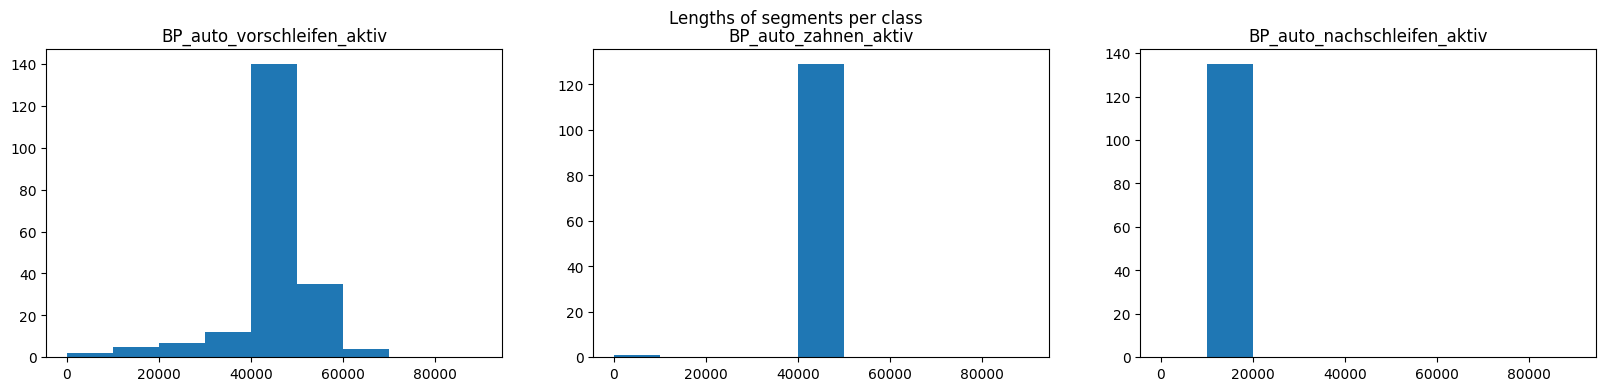

In [5]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
fig.suptitle("Lengths of segments per class")
for i in np.arange(3):
    ax[i].hist(class_segs_lens_aug[i], bins = 10000 * np.arange(start =0, stop=10))
    ax[i].set_title(classes[i])

Die Segmente haben unterschiedliche Längen. Allerdings müssen für alle Methoden, außer D_DTW NN, die Datenpunkte dieselbe Länge haben. Dazu kommen wir gleich zurück. 

In den Rohdaten hat jede Klasse ihre eigene Spalte, die True/False Werte enthält, die angeben, ob sich der Zeitpunkt in der zugehörigen Phase befindet. Die Funktion `get_class_labels` überprüft, ob ein Messpunkt mehreren Phasen zugeordnet wird und erstellt andernfalls eine weitere Spalte, die die eindeutige Klassenzuweisung angibt. Hier haben wir die Korresponden:

1: Vorschleifen

2: Zahnen

3: Nachschleifen

In [6]:
def get_class_labels(data):
    """
    data: pandas dataframe as extracted by the to_pandas function. 
    We check if any points are in multiple classes at the same time. In case there are no conflicts we add a column consisting of the unique class label of each point. 
    """
    class_conflict = data[classes].sum(axis = 1) > 1
    indices = class_conflict[class_conflict].index
    if len(indices) > 0:
        print("Multiple classes at the same time.")
        return(indices)
    else:
        print("No class conflicts.")
        data.loc[:, "which_class"] = 0
        data.loc[data[c1] == 1, 'which_class'] = 1
        data.loc[data[c2] == 1, 'which_class'] = 2
        data.loc[data[c3] == 1, 'which_class'] = 3
        return(data)

def make_colormap_classes(fig):
    """ 
    Helper function for coloring the different classes
    """
    RR = [136, 170, 68, 136]
    GG = [136, 68, 170, 204]
    BB = [136, 153, 153, 238]
    colors = np.c_[RR, GG, BB] / 255
    my_cmap = mpl.colors.LinearSegmentedColormap.from_list('RADAR', colors)
    VariableLimits = np.array([0, 1, 2, 3])
    norm = mpl.colors.BoundaryNorm(np.append(VariableLimits, 1000), ncolors=256)
    ax_leg = fig.add_axes([0.95, 0.1, 0.01, 0.8])
    cb = mpl.colorbar.ColorbarBase(ax_leg, cmap=my_cmap,ticks=VariableLimits, norm = norm, format='%1i')
    cb.set_ticklabels(names)
    return(my_cmap, norm)


def plot(data, step = 1):
    """
    data: pandas dataframe as extracted by the to_pandas function. 
    Plots all 16 variables and colors them according to their class label. 
    """
    if "which_class" not in data.columns:
        data = get_class_labels(data)
    rows = int(np.ceil(len(chans)/4))
    fig, ax =  plt.subplots(rows, 4, figsize = (25, 2.5*rows) )
    my_cmap, norm = make_colormap_classes(fig)
    for i in np.arange(len(chans)):
        row = int(np.floor(i/4))
        ax[row, i - row*5].scatter(x = np.arange(len(data), step = step), y = data[chans[i]][::step], c = data["which_class"][::step],cmap = my_cmap, norm = norm, s = 20 ,alpha = 0.8, edgecolors = "None")
        ax[row, i - row*5].set_title(chans[i])
        ax[row, i - row*5].get_xaxis().set_visible(False)

def plot_np(data, c = [0],step = 1, chan_names = chans, width = 25, height = 2.5):
    """
    data: np array of shape (n_timesteps, n_dimensions)
    c: array-like of class labels (0, 1, 2, or 3), if len(c) = 1 then every point is assumed to be in class c
    Plots all 16 variables and colors them according to c 
    """
    n_dims = data.shape[1]
    rows = int(np.ceil(n_dims/4))
    fig, ax =  plt.subplots(rows, 4, figsize = (width, height*rows) )
    x = np.arange(len(data), step = step)    
    for i in np.arange(n_dims):
        row = int(np.floor(i/4))
        if len(c) ==1:
            if c[0] in [1, 2, 3]:
                my_cmap, norm = make_colormap_classes(fig)
                ax[row, i - row*5].scatter(x = x, y = data[::step, i], c = np.repeat(c[0], len(x)),cmap = my_cmap, norm = norm, s = 15 ,alpha = 0.8, edgecolors = "None")
            else:
                ax[row, i - row*5].scatter(x = x, y = data[::step, i], s = 20 ,alpha = 0.8, edgecolors = "None")
        else:
            my_cmap, norm = make_colormap_classes(fig)
            ax[row, i - row*5].scatter(x = x, y = data[::step, i], c =c,cmap = my_cmap, norm = norm, s = 15 ,alpha = 0.8, edgecolors = "None")
        ax[row, i - row*5].set_title(chan_names[i])
        ax[row, i - row*5].get_xaxis().set_visible(False)

Wir visualisieren jeweils ein Beispiel für ein Segment pro Klasse. In jedem Scatterplot wird eine Messgröße abgebildet, wobei wir aufgrund der häufigen Messungen, nur jeden hundertsten Punkt zeigen. Die Farbe entspricht der Klasse des Segments. <br>


No class conflicts.


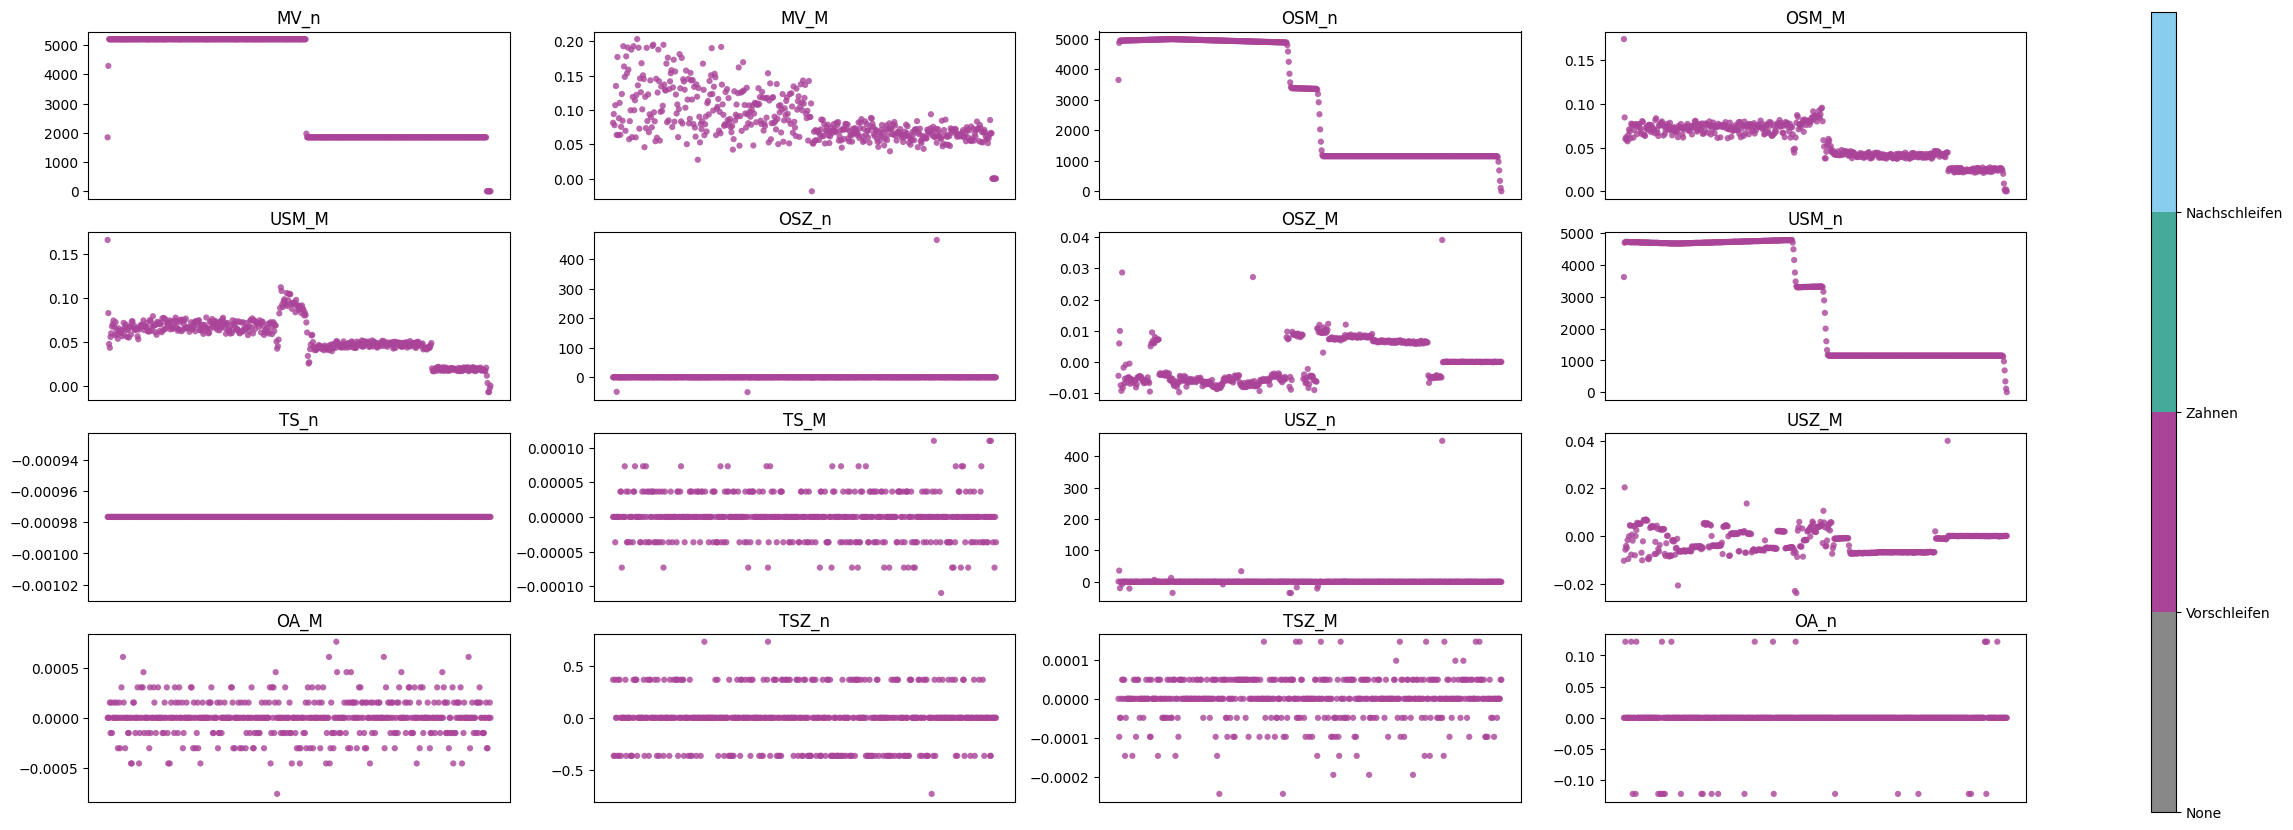

In [7]:
plot(inst_dict[c1][100], step = 100)

No class conflicts.


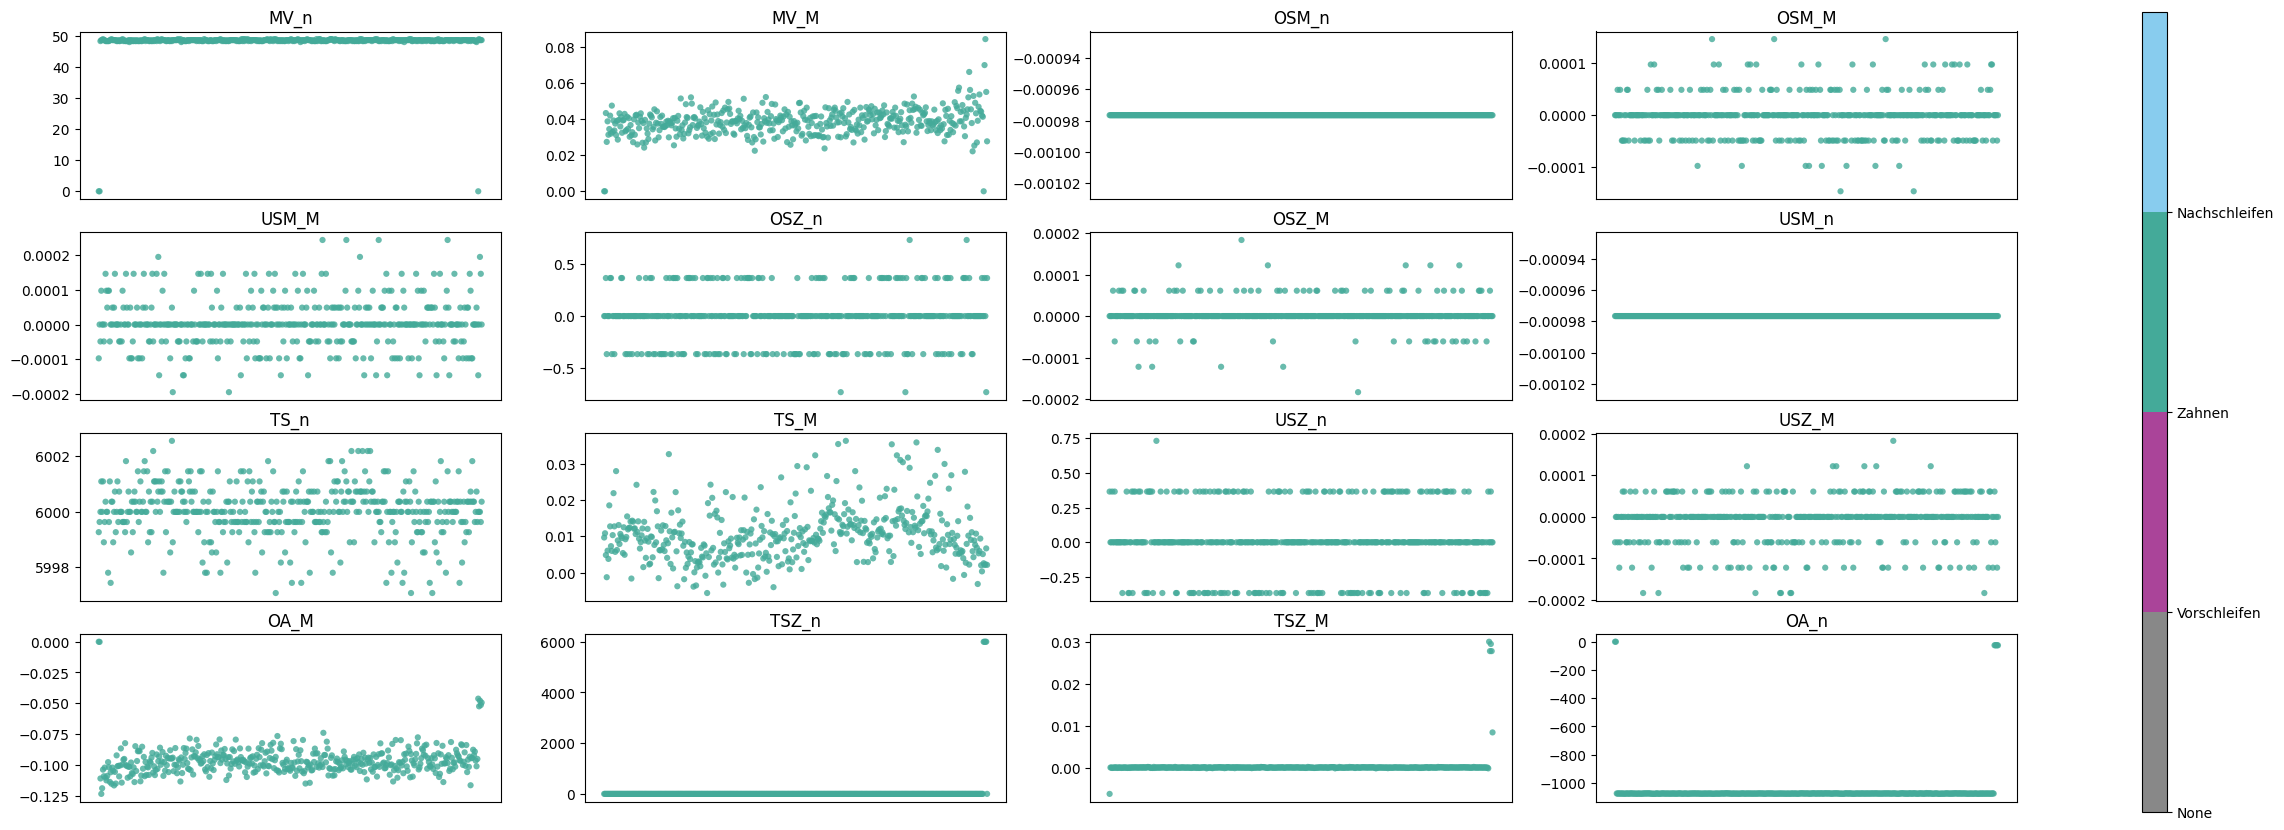

In [8]:
plot(inst_dict[c2][100], step = 100)

No class conflicts.


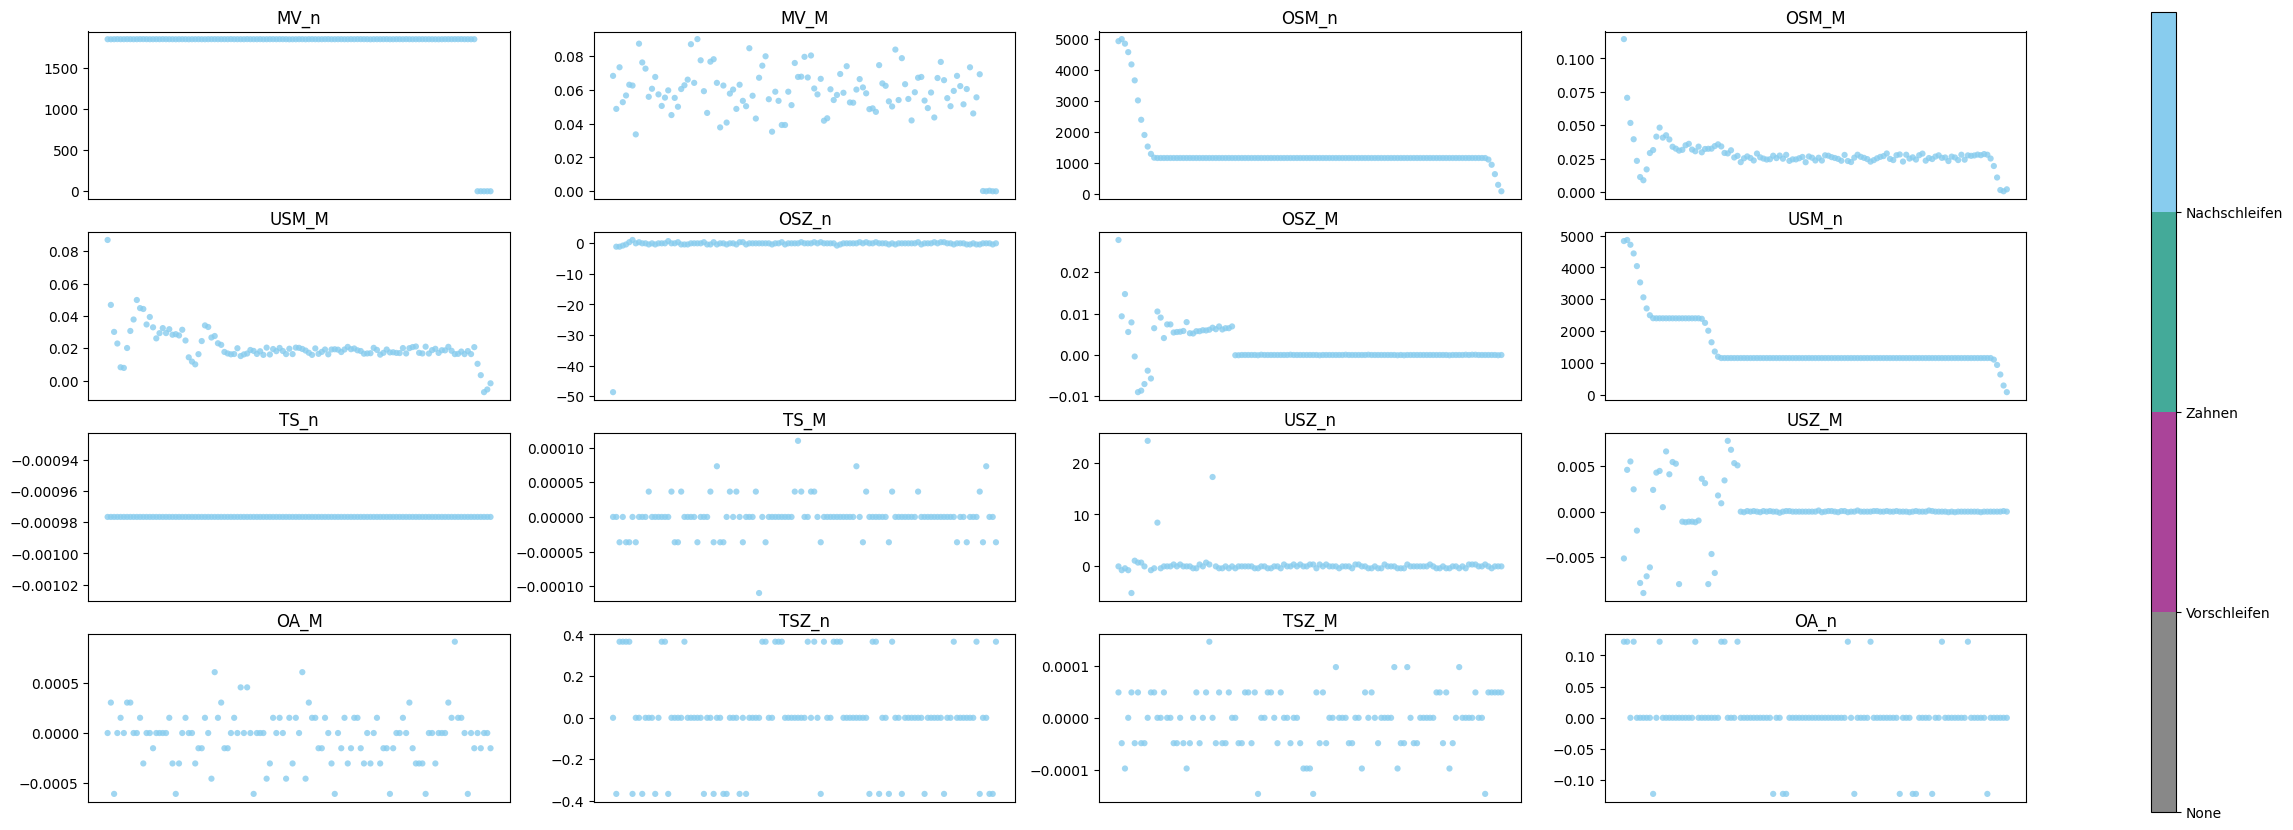

In [9]:
plot(inst_dict[c3][100], step = 100)

Nun kommen wir zu den Funktionen, die das Dictionary in einen Numpy Array mit Shape `(n_segments, max_len, n_dim)` umwandeln. Wobei hier `n_dim` die Anzahl unserer Variablen, also hier 16, beschreibt und `max_len` die Länge bezeichnet, auf die wir die einzelnen Segmente entweder zusammenstauchen oder strecken. 

Um ein Segment zu strecken, interpolieren wir linear zwischen den Messungen.

Um zu stauchen, nehmen wir den Mittelwert über die nötige Anzahl von Zeitpunkten, die wir zu einem zusammenfassen müssen. Die Funktion `make_sparse` ist allgemeiner gehalten, als an dieser Stelle notwendig, da sie beim Stauchen zusätzlich die häufigste Klassenzuweisung ermittelt und diese dem neuen Punkt zuordnet. In dem aktuellen Datentyp haben natürlich alle Zeitpunkte in einem Segment dieselbe Klasse, aber dieser Schritt wird später für die Fenster relevant. 

Für D_DTW NN müssen wir nicht Daten derselben Länge haben. Die Funktion `padd_with_nans` bringt das Dictionary in das richtige Format für diese Methode und fasst ggf. Zeitpunkte zusammen, um eine schnellere Laufzeit zu gewährleisten. 

In [10]:
def get_most_common(data):
    """
    Helper funcion for extracting the most common element in a column
    """
    my_counter = Counter(list(data))
    return my_counter.most_common(1)[0][0] # in case of multiple modes choose first one
    
def make_sparse(data, step = 100):
    """
    data: pandas dataframe as extracted by the to_pandas function
    Takes mean over every steps timepoints and returnes the transformed dataframe. 
    """
    if "which_class" in  data.columns:
        which_class = data["which_class"].groupby(np.arange(len(data))//step).agg(get_most_common) 
        data.drop(["which_class"], axis = 1)
        data = data.groupby(np.arange(len(data))//step).mean()
        data["which_class"] = which_class
        return(data)
    else:
        return(data.groupby(np.arange(len(data))//step).mean())

def stretch_and_compress_dict(inst_dict, max_len, channels = chans):
    """
    inst_dict: dictionary of class instances
    max_len: final length of each transformed segment
    channels: which columns to return
    Returns a numpy array of shape (n_segments, max_len, len(channels))
    We subset the relevant columns and either stretch or compress each segment to the length max_len. 
    """
    num_class_segs = [len(inst_dict[c1]), len(inst_dict[c2]), len(inst_dict[c3])]
    n_dim = len(channels)
    key_list = [*inst_dict.keys()]
    segs = np.zeros(shape = (np.sum(num_class_segs), max_len, n_dim))
    for j in np.arange(len(inst_dict.keys())):
        key = key_list[j]
        for i in np.arange(len(inst_dict[key])):
            seg = inst_dict[key][i].loc[:, channels]
            index = i
            for k in np.arange(j):
                index += len(inst_dict[key_list[k]])
            #stretch
            if len(seg) < max_len:
                for d in np.arange(n_dim):
                    segs[index,:, d] = np.interp(np.linspace(0, 1, int(max_len)), np.linspace(0, 1, len(seg)), seg.iloc[:, d])
            #compress
            else:
                segs[index, :, :] = make_sparse(seg, len(seg)/max_len)
    return(segs)

def padd_with_nans(inst_dict, channels = chans, step = 100):
    """
    inst_dict: dictionary of class instances
    channels: which columns to return
    step : how many steps to summarize in each segment
    returns a np array of shape (n_segments, max_len, len(channels)) where each segment is filled up with NaNs to the maximum length of all segments 
    """
    from tslearn.utils import to_time_series_dataset
    key_list = [*inst_dict.keys()]
    segs = []
    for j in np.arange(len(inst_dict.keys())):
        key = key_list[j]
        for i in np.arange(len(inst_dict[key])):
            segs.append(make_sparse(inst_dict[key][i].loc[:, channels], step))
    segs = to_time_series_dataset(segs)
    return(segs)

In [11]:
X_segments = stretch_and_compress_dict(inst_dict, max_len = 20000)
X_segments_nans = padd_with_nans(inst_dict)
del(inst_dict) 

### Fenster

Um aus dem Datenstrom Fenster zu erhalten, laufen wir in Schritten der Länge `increment` über den Strom und speichern nach jedem Schritt ein Fenster der Länge `window_length`. <br>
Da die Messungen in jeder Millisekunde vorgenommen wurden und daher hochfrequent sind, fassen wir zusätzlich noch alle `sparse_step` Zeitpunkte zusammen, indem wir den Mittelwert nehmen (siehe `make_sparse` in dem Abschnitt zuvor). 
Dies führt zu einer schnelleren Laufzeit und es ist zu erwarten, dass wir dabei wenig Informationen verlieren. <br>
Die Fenster speichern wir in einem Numpy Array mit Shape `(n_windows, window_length//sparse_step, n_dim)`, wobei hier `n_dim` = 17 ist, da wir zusätzlich zu den Messgrößen noch eine Spalte haben, die die Klassenzuweisung pro Punkt speichert. 

Wir brauchen zusätzliche Klassenbezeichnungen um Fenster einzuteilen, in denen mehrere der anfänglichen drei Klassen vorkommen. Außerdem betrachten wir den Fall, dass jeder Punkt in einem Fenster keine Klassenzuweisung hat. 

0: None

1: Vorschleifen

2: Zahnen

3: Nachschleifen

4: Sowohl 1, als auch 2

5: Sowohl 1, als auch 3

6: Sowohl 2, als auch 3

7: Sowohl 1, als auch 2, als auch 3

Manche Methoden sind langsamer als andere und es kann nötig sein, noch mehr Zeitpunkte zusammenzufassen. Damit wir nicht jedes Mal, die Fenster neu extrahieren müssen, gibt es die Funktion `make_sparse_np`, die ein Fenster auf eine beliebige Länge reduziert.

Um Fenster sinnvoll zu Segmenten zusammenfassen zu können, brauchen wir eine sehr gute Genauigkeit unserer Klassifizierung. 
Wir werden in dem Abschnitt zu den Methoden sehen, dass dies in unserem Beispiel nur möglich ist, wenn man Vor- und Nachschleifen als eine Klasse betrachtet. Daher erstellen wir auch eine einfachere Version der oben beschriebenen Einteilung, die aus der originalen Einteilung durch die Funktion `make_y_simple` erhalten wird. In diesem Beispiel könnte man das Problem auch mit dem Vorwissen lösen, dass Vorschleifen immer von Nachschleifen durch Zahnen getrennt wird, aber wir wollen in einem allgemeinerem Szenario ohne dieses Vorwissen bleiben. In diesem, einfacheren Fall haben wir also die folgenden Klassen.

0: None

1: Vorschleifen oder Nachschleifen oder Beides

2: Zahnen

3: Zahnen und eine der Schleifen-Klassen

In [14]:
def get_windows(data_pd,  window_length = 20000, increment = 5000,  sparse_step = 10):
    """
    data_pd: pandas dataframe as extracted by the to_pandas function
    returns a pandas dataframe consisting of the stacked windows and another dataframe showing which classes are present in each window
    """
    window_list= []
    y = pd.DataFrame(data = {c1:[], c2 : [], c3 : []})
    none_count = 0
    for day in data_pd:
        day = get_class_labels(day)[chans + ["which_class"]]
        for i in np.arange(len(day), step = increment):
            window = day.iloc[i:(i+window_length)]
            window_list.append(make_sparse(window, step = sparse_step))
            y = pd.concat([y,pd.DataFrame(data = {c1:[any(1 == window["which_class"])], c2 : [any(2 == window["which_class"])], c3 : [any(3 == window["which_class"])]}) ])
    print("Returned", len(window_list), "windows") 
    return(pd.concat(window_list), y)

def make_numpy_windows(X_windows_pd, y_windows_pd):
    """
    X_windows_pd, y_windows_pd: pd dataframes as extracted by get_windows
    returns a numpy array of shape (n_windows, window_length//sparse_step, n_dim) and a vector consisting of the final class labels of each window
    """
    c1_windows = np.where(y_windows_pd[c1])[0]
    c2_windows= np.where(y_windows_pd[c2])[0]
    c3_windows= np.where(y_windows_pd[c3])[0]
    none_windows= np.where((y_windows_pd[[c1, c2, c3]] == [0, 0, 0]).all(axis="columns"))[0]
    only_c1_windows= np.setdiff1d(np.setdiff1d(c1_windows, c2_windows), c3_windows)
    only_c2_windows= np.setdiff1d(np.setdiff1d(c2_windows, c1_windows), c3_windows)
    only_c3_windows= np.setdiff1d(np.setdiff1d(c3_windows, c2_windows), c1_windows)
    conflict_windows= np.setdiff1d(np.arange(len(y_windows_pd)), np.concatenate((only_c1_windows, only_c2_windows, only_c3_windows, none_windows)))
    y_conflicts = np.zeros(len(conflict_windows))
    for i in np.arange(len(conflict_windows)):
        if sum(y_windows_pd.iloc[conflict_windows[i], :]) ==2:
            if y_windows_pd.iloc[conflict_windows[i], 1] ==1:
                if y_windows_pd.iloc[conflict_windows[i], 2] ==1:
                    y_conflicts[i] = 4
                else:
                    y_conflicts[i] = 5
            else:
                y_conflicts[i] = 6 
        else:
            y_conflicts[i] = 7
    X_windows = []
    y_windows = []
    for i in np.arange(len(X_windows_pd), step = 2000):
        if i+2000 <= len(X_windows_pd): #remove partial windows
            X_windows.append(X_windows_pd.iloc[i:(i+2000), 1:].to_numpy())
            if sum( y_windows_pd.iloc[i//2000, :]) == 0:
                y_windows.append(0)
            elif sum( y_windows_pd.iloc[i//2000, :]) == 1:
                y_windows.append(np.where(y_windows_pd.iloc[i//2000, :])[0][0])
            elif sum( y_windows_pd.iloc[i//2000, :]) > 1:
                y_windows.append(y_conflicts[np.where(conflict_windows == i//2000)[0][0]])
    X_windows = np.stack(X_windows)
    y_windows = np.array(y_windows)
    return(X_windows, y_windows)

def make_sparse_np(data, step = 100):
    """
    data: np array as returned by make_numpy_windows
    returns a np array with dimension 2 reduced by //step by taking the average over every step points
    """
    steps = np.arange(data.shape[2], step = step, dtype=np.int32)
    sparse_data = np.zeros((data.shape[0], data.shape[1], int(np.ceil(data.shape[2]/step))))
    for i in np.arange(len(steps) - 1): 
        sparse_data[:, :, i] = np.mean(data[:, :, steps[i]:steps[i+1]], axis = 2)
    sparse_data[:, :, -1] = np.mean(data[:, :, steps[-1]:], axis = 2)
    return(sparse_data) 
    
def make_y_simple(y):
    """
    y: np array of class labels as returned by make_numpy_windows
    returns a np array consisting of the simplified class labels
    """
    y_simple = np.zeros(len(y))
    for i in np.arange(len(y)):
        if y[i] in [1, 3]:
            y_simple[i] = 1
        elif y[i] in [0, 2]:
            y_simple[i] = y[i]
        elif y[i] in [4, 6, 7]:
            y_simple[i] = 3
        elif y[i] == 5:
            y_simple[i] = 1
    return(y_simple)

In unseres Beispieldaten gehören die allermeisten Fenster zu der None-Klasse. Im Folgenden laden wir daher einen Datensatz, indem nur ein Teil der None-Fenster behalten wurde. Diese reichen, um zu demonstrieren, dass wir sie gut von den anderen Klassen unterscheiden können. 

In [15]:
X_windows = np.load("/home/ndv/stud/xgerloff/X_windows_aug.npy")
X_windows = X_windows[:, :, :-1] #remove which_class column
y_windows = np.load("/home/ndv/stud/xgerloff/y_windows_aug.npy")
no_conflict_windows = np.where(y_windows < 4)[0] # indices of windows where only one original class is present
y_windows_simple = make_y_simple(y_windows)

Der zweite Datensatz besteht aus allen Fenstern von einem Tag. An diesem demonstrieren wir, wie man die Fenster zu einem Segment zusammenfügen kann. <br>
Hierfür speichern wir auch die Rohdaten von diesem Tag und bestimmen die Start- und Endpunkte der Segmente zum späteren Vergleich mit unseren Ergebnissen. 

In [16]:
X_continuous_windows_pd = pd.read_csv("/home/ndv/stud/xgerloff/continuous_windows.csv")
y_continuous_windows_pd = pd.read_csv("/home/ndv/stud/xgerloff/y_continuous_windows.csv")
X_continuous_windows, y_continuous_windows = make_numpy_windows(X_continuous_windows_pd, y_continuous_windows_pd)
X_continuous_windows = X_continuous_windows[:, :, :-1] #remove which_class column
y_continuous_windows_simple = make_y_simple(y_continuous_windows)
del(X_continuous_windows_pd)
del(y_continuous_windows_pd)
len(X_continuous_windows)

1726

In [17]:
#get raw data
path = "/home/ndv/stud/data/Bäumer/CGM/database_mat_day/CGM/BAEUMER/2022_09_September/2022_09_01_Thu_CGM_BAEUMER.mat"
matdata = loaddata([path])
raw_data_pd = to_pandas(matdata)
raw_data_pd = get_class_labels(raw_data_pd[0])

# get true timestamps
timestamps = []
min_length = 7000
for i in np.arange(len(raw_data_pd) - 1):
    if raw_data_pd.which_class[i] != raw_data_pd.which_class[i+1]:
        if len(timestamps) == 0:
            if i+1 > min_length:
                timestamps.append([0, i+1])
        else:
            if i+1 - timestamps[-1][1] > min_length:
                timestamps.append([timestamps[-1][1], i+1])

loading data ...
converting to pandas ...
processing matfile
No class conflicts.


## Methoden

Um zu bestimmen, welche Methode sich am Besten eignet, bestimmen wir die Genauigkeit der Klassifizierung über verschiedene Trainings- und Testdaten und ihre Laufzeit. <br>
In `test_classifier` setzt man unter anderem den Random Seed, der zu der Unterteilung in Trainings- und Testdaten benutzt wird. Um die Methoden zu vergleichen, benutzen wir denselben Seed für jeden Aufruf von `test_classifier`.<br>
In diesem Abschnitt vergleichen wir die Methoden für die Klassifizierung von Segmenten. <br>


In [15]:
def acc(y_pred, y_test):
    """
    y_pred: np array of predicted labels
    y_test: np array of true labels
    returns the achieved accuracy
    """
    return(1 - sum(abs(y_pred  - y_test))/len(y_test))
    
def test_classifier(fit_predict, X, y, N = 5, seed = 111, test_size = 0.25, get_data = False):
    """ 
    fit_predict: function taking the arguments X_train, y_train, X_test and returning the predicted labels y_pred of X_test and 
                 the time it took to classify X_test based on X_train and y_train
    X: np array, where the first axis corresponds to the no. of instances
    y: np array of true labels of X
    N: no. of train/test splits to perform
    seed: random seed for the train/test splits
    test_size: percentage of n_instances to be used as a test set
    get_data: whether to return the train/test data

    For each train/test split we print the achieved accuracy and the confusion matrix. 
    We also print the overall average accuracy, time, train and test size.
    The accuracies, confusion matrices and times are always returned. 
    If get_data is true, then lists of the train and test data are also returned.
    """
    np.random.seed(seed)
    random_states = np.random.randint(0, high = 999999, size = N)
    times = np.zeros(N)
    X_train_sizes = np.zeros(N)
    X_test_sizes = np.zeros(N)
    train_data = []
    test_data = []
    
    results = []
    for i in np.arange(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=random_states[i], stratify = y)
        X_train_sizes[i] = len(X_train)
        X_test_sizes[i] = len(X_test)
        y_pred, time = fit_predict(X_train, y_train, X_test)
        times[i] = time
        results.append([acc(y_pred, y_test), confusion_matrix(y_test, y_pred)])

        if get_data:
            train_data.append([X_train, y_train]) 
            test_data.append([X_test, y_test, y_pred])
    sum_acc = 0
    for i in np.arange(N):
        print("Acc.:")
        print(results[i][0])
        print("Confusion matrix:")
        print(results[i][1])
        sum_acc += results[i][0]
    print("\nAvg. accuracy:", np.round(sum_acc/N, 5),"Avg. time:", np.mean(times), "\nAvg. train size:",np.mean(X_train_sizes),"Avg. test size:", np.mean(X_test_sizes))

    return(results, times, train_data, test_data)  

### Canonical Interval Forest (CIF)
Die grundlegende Methode ist in [1] beschrieben. <br>
Die Idee ist, zufällige Intervalle auszuwählen, auf denen verschiedene, ebenfalls zufällig ausgewählte 
statistische Indikatoren berechnet werden. Diese neuen Features werden mit einem Entscheidungsbaum (siehe zum Beispiel [hier](https://scikit-learn.org/stable/modules/tree.html)) klassifiziert. <br>
Wir haben den Algorithmus auf unsere Anwendung angepasst. Unsere Indikatoren werden aus den Folgenden ausgewählt (Die iher genannten Namen werden in der Visualisiereung des Entscheidungsbaums benutzt).


DN_HistogramMode_5 : Modalwert des 5-Bin Histograms

DN_HistogramMode_10 :  Modalwert des 10-Bin Histograms

SB_BinaryStats_mean_longstretch1 : Längste Zeitspanne von aufeinanderfolgenden Werten über dem Mittelwert 

DN_OutlierInclude_p_001_mdrmd : Relative Position von Punkten über dem Mittelwert (-1 dem Anfang des Intervalls, 0 entspricht der Mitte, 1 dem Ende)

DN_OutlierInclude_n_001_mdrmd : Relative Position von Punkten unter dem Mittelwert (-1 dem Anfang des Intervalls, 0 entspricht der Mitte, 1 dem Ende)

MD_hrv_classic_pnn40 : Anteil von Sprüngen zwischen Punkten, die größer als 0.04*Standardabweichung sind. 

SB_BinaryStats_diff_longstretch0 :  Längste Zeitspanne von aufeinanderfolgend absteigenden Werten

FC_LocalSimple_mean1_tauresrat : Zeitpunkt der ersten Nullstelle der Autokorrelation der Sprünge zwischen aufeinanderfolgenden Punkte. 

Und schließlich noch die Folgenden, weniger komplexen Indikatoren: <br>
iqr (Interquantilsabstand), mean (Mittelwert), median (Median), max (Maximum), min (Minimum), slope (Steigunge der Regressionsgerade), std (Standardabweichung)

Genauere Beschreibungen findet man in [2] and [hier](https://feature-based-time-series-analys.gitbook.io/catch22-features/). 

In [20]:
"""
Modified class method for sktime's CIF
"""
import math
import numpy as np
from joblib import Parallel, delayed
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_random_state

from sktime.base._base import _clone_estimator
from sktime.classification.base import BaseClassifier
from sktime.classification.sklearn._continuous_interval_tree import (
    ContinuousIntervalTree,
    _drcif_feature,)
from sktime.transformations.panel.catch22 import Catch22

class my_CIT(CanonicalIntervalForest): 
    def _fit_estimator(self, X, y, idx):#this method replaces the original sktime method
        c22 = Catch22(outlier_norm=True)
        rs = 255 if self.random_state == 0 else self.random_state
        rs = (
            None
            if self.random_state is None
            else (rs * 37 * (idx + 1)) % np.iinfo(np.int32).max
        )
        rng = check_random_state(rs)

        transformed_x = np.empty(
            shape=(self._att_subsample_size * self._n_intervals, self.n_instances_),
            dtype=np.float32,
        )

        atts = rng.choice([0, 1, 2, 3, 4, 13, 14, 16, 22, 23, 24, 25, 26, 27, 28 ], self._att_subsample_size, replace=False)
        dims = rng.choice(self.n_dims_, self._n_intervals, replace=True)
        intervals = np.zeros((self._n_intervals, 2), dtype=int)

        # Find the random intervals for classifier i and concatenate
        # features
        for j in range(0, self._n_intervals):
            if rng.random() < 0.5:
                intervals[j][0] = rng.randint(
                    0, self.series_length_ - self._min_interval
                )
                len_range = min(
                    self.series_length_ - intervals[j][0],
                    self._max_interval,
                )
                length = (
                    rng.randint(0, len_range - self._min_interval) + self._min_interval
                    if len_range - self._min_interval > 0
                    else self._min_interval
                )
                intervals[j][1] = intervals[j][0] + length
            else:
                intervals[j][1] = (
                    rng.randint(0, self.series_length_ - self._min_interval)
                    + self._min_interval
                )
                len_range = min(intervals[j][1], self._max_interval)
                length = (
                    rng.randint(0, len_range - self._min_interval) + self._min_interval
                    if len_range - self._min_interval > 0
                    else self._min_interval
                )
                intervals[j][0] = intervals[j][1] - length

            for a in range(0, self._att_subsample_size):
                transformed_x[self._att_subsample_size * j + a] = _drcif_feature(
                    X, intervals[j], dims[j], atts[a], c22, case_id=j
                )

        tree = _clone_estimator(self._base_estimator, random_state=rs)
        transformed_x = transformed_x.T
        transformed_x = transformed_x.round(8)
        if self.base_estimator == "CIT":
            transformed_x = np.nan_to_num(
                transformed_x, False, posinf=np.nan, neginf=np.nan
            )
        else:
            transformed_x = np.nan_to_num(transformed_x, False, 0, 0, 0)
        tree.fit(transformed_x, y)

        return [tree, intervals, dims, atts]

Für CIF haben wir eine separate Analysefunktion `analyse_tree`, da wir mehr Informationen als in `test_classifier` zeigen wollen: <br>
Die Entscheidungsfindung wird durch ein Baumdiagramm visualisiert. Dadurch bekommen wir interpretierbare Resultate. 

In [21]:
feature_names = [
    "DN_HistogramMode_5",
    "DN_HistogramMode_10",
    "SB_BinaryStats_diff_longstretch0",
    "DN_OutlierInclude_p_001_mdrmd",
    "DN_OutlierInclude_n_001_mdrmd",
    "CO_f1ecac",
    "CO_FirstMin_ac",
    "SP_Summaries_welch_rect_area_5_1",
    "SP_Summaries_welch_rect_centroid",
    "FC_LocalSimple_mean3_stderr",
    "CO_trev_1_num",
    "CO_HistogramAMI_even_2_5",
    "IN_AutoMutualInfoStats_40_gaussian_fmmi",
    "MD_hrv_classic_pnn40",
    "SB_BinaryStats_mean_longstretch1",
    "SB_MotifThree_quantile_hh",
    "FC_LocalSimple_mean1_tauresrat",
    "CO_Embed2_Dist_tau_d_expfit_meandiff",
    "SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1",
    "SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1",
    "SB_TransitionMatrix_3ac_sumdiagcov",
    "PD_PeriodicityWang_th0_01",
    "mean", "std", "slope", "median", "iqr", "min", "max"
]

def make_feature_names(n_intervals, atts, feature_names=feature_names, order = "interval"):
    """
    Helper function to visualize the decision tree
    """
    if order == "interval":
        feature_names_interval = []
        subset = [feature_names[i] for i in atts]
        for i in np.arange(n_intervals):
            for name in subset:
                feature_names_interval.append(str(i) + "_" + name)
    else:
        feature_names_interval = []
        subset = [feature_names[i] for i in atts]
        for name in subset:
            for i in np.arange(n_intervals):
                feature_names_interval.append(str(i) + "_" + name)
    return(feature_names_interval)


def show_intervals(max_len, intervals, intervals_used, dims):
    """
    Helper function to visualize the decision tree
    """
    from matplotlib.lines import Line2D
    fig, ax = plt.subplots(figsize = (10, 3))
    ax.plot(np.arange(max_len), np.repeat(-1, max_len), color = "grey")
    for i in np.arange(len(intervals_used)):
        ax.plot(np.arange(start = intervals[int(intervals_used[i])][0], stop = intervals[int(intervals_used[i])][1]), 
                                np.repeat(i, intervals[int(intervals_used[i])][1] - intervals[int(intervals_used[i])][0]), color = "black")
        ax.annotate(chans[dims[i]], (intervals[int(intervals_used[i])][1]+10, i))
        ax.annotate(str(intervals_used[i]), (intervals[int(intervals_used[i])][0]-20, i))


def analyse_tree(X_train, y_train, min_interval, max_interval, n_intervals, random_state, class_names, n_attr = 8, X_test = "",y_test = "", filename ="tree"):
    """
    X_train: np array of shape (n_instances, n_dimensions, n_timesteps) 
    y_train: np array of training labels
    min_interval: minimal interval length
    max_interval: maximal interval length
    n_intervals: no. of intervals to choose
    random_state: random state for building the classifier
    class_names: list of names for the labels in y_train (in ascending order)
    n_attr: no. if indicators to compute per interval
    X_test: optional test data of the same type as X_train
    y_test: optional test labels
    filename: string for saving the visualization of the graph 

    Saves a visualization of the trained classifier and shows the intervals used. 
    Returns the name of the file (use display(Image(name, width=300)) to display), the dimensions of the intervals, their timestamps, 
    the indicators computed and the names of the indicators which ended up in the trained classifier. 
    If test data is given we print the accuracy, confusion matrix  and time needed to predict.
    """
    from subprocess import call
    CIF_classifier =  my_CIT(n_estimators= 1, base_estimator="DTC", min_interval=min_interval, max_interval=max_interval, n_intervals=n_intervals, 
                    att_subsample_size = n_attr, random_state=random_state)
    CIF_classifier.fit(X_train, y_train)
    atts = CIF_classifier.atts_[0]
    dims = CIF_classifier.dims_[0]
    intervals = CIF_classifier.intervals_[0]
    feat_used = np.where(CIF_classifier.estimators_[0].feature_importances_ != 0)[0]
    feature_names = make_feature_names(n_intervals, atts)
    names_used = [feature_names[i] for i in feat_used]
    intervals_used = []
    for i in np.arange(len(names_used)):
        intervals_used.append(int(names_used[i].split("_")[0]))
    intervals_used = np.unique(intervals_used)
    show_intervals(X_train.shape[-1], intervals = intervals, intervals_used = intervals_used, dims = dims[intervals_used])
    exported = tree.export_graphviz(CIF_classifier.estimators_[0], out_file="imgs/tree.dot", class_names=class_names, rounded = True, 
                                    feature_names=feature_names) 
    call(['dot', '-Tpng', 'imgs/tree.dot', '-o', "imgs/"+filename+".png", '-Gdpi=600'])

    if len(X_test)> 0:
        st = time.time()
        y_pred = CIF_classifier.predict(X_test)
        en = time.time()  
        print("Time for predicting:", en - st)  
        print("Accuracy:", acc(y_test, y_pred))
        print("Confusion matrix:")
        print(confusion_matrix(y_pred, y_test))
        return(y_pred, "imgs/"+ filename+".png", dims, intervals, atts, names_used)
    else:
            return("imgs/"+filename+".png", dims, intervals, atts, names_used)


Time for predicting: 89.23080563545227
Accuracy: 0.9744680851063829
Confusion matrix:
[[100   0   0]
 [  0  65   0]
 [  3   0  67]]


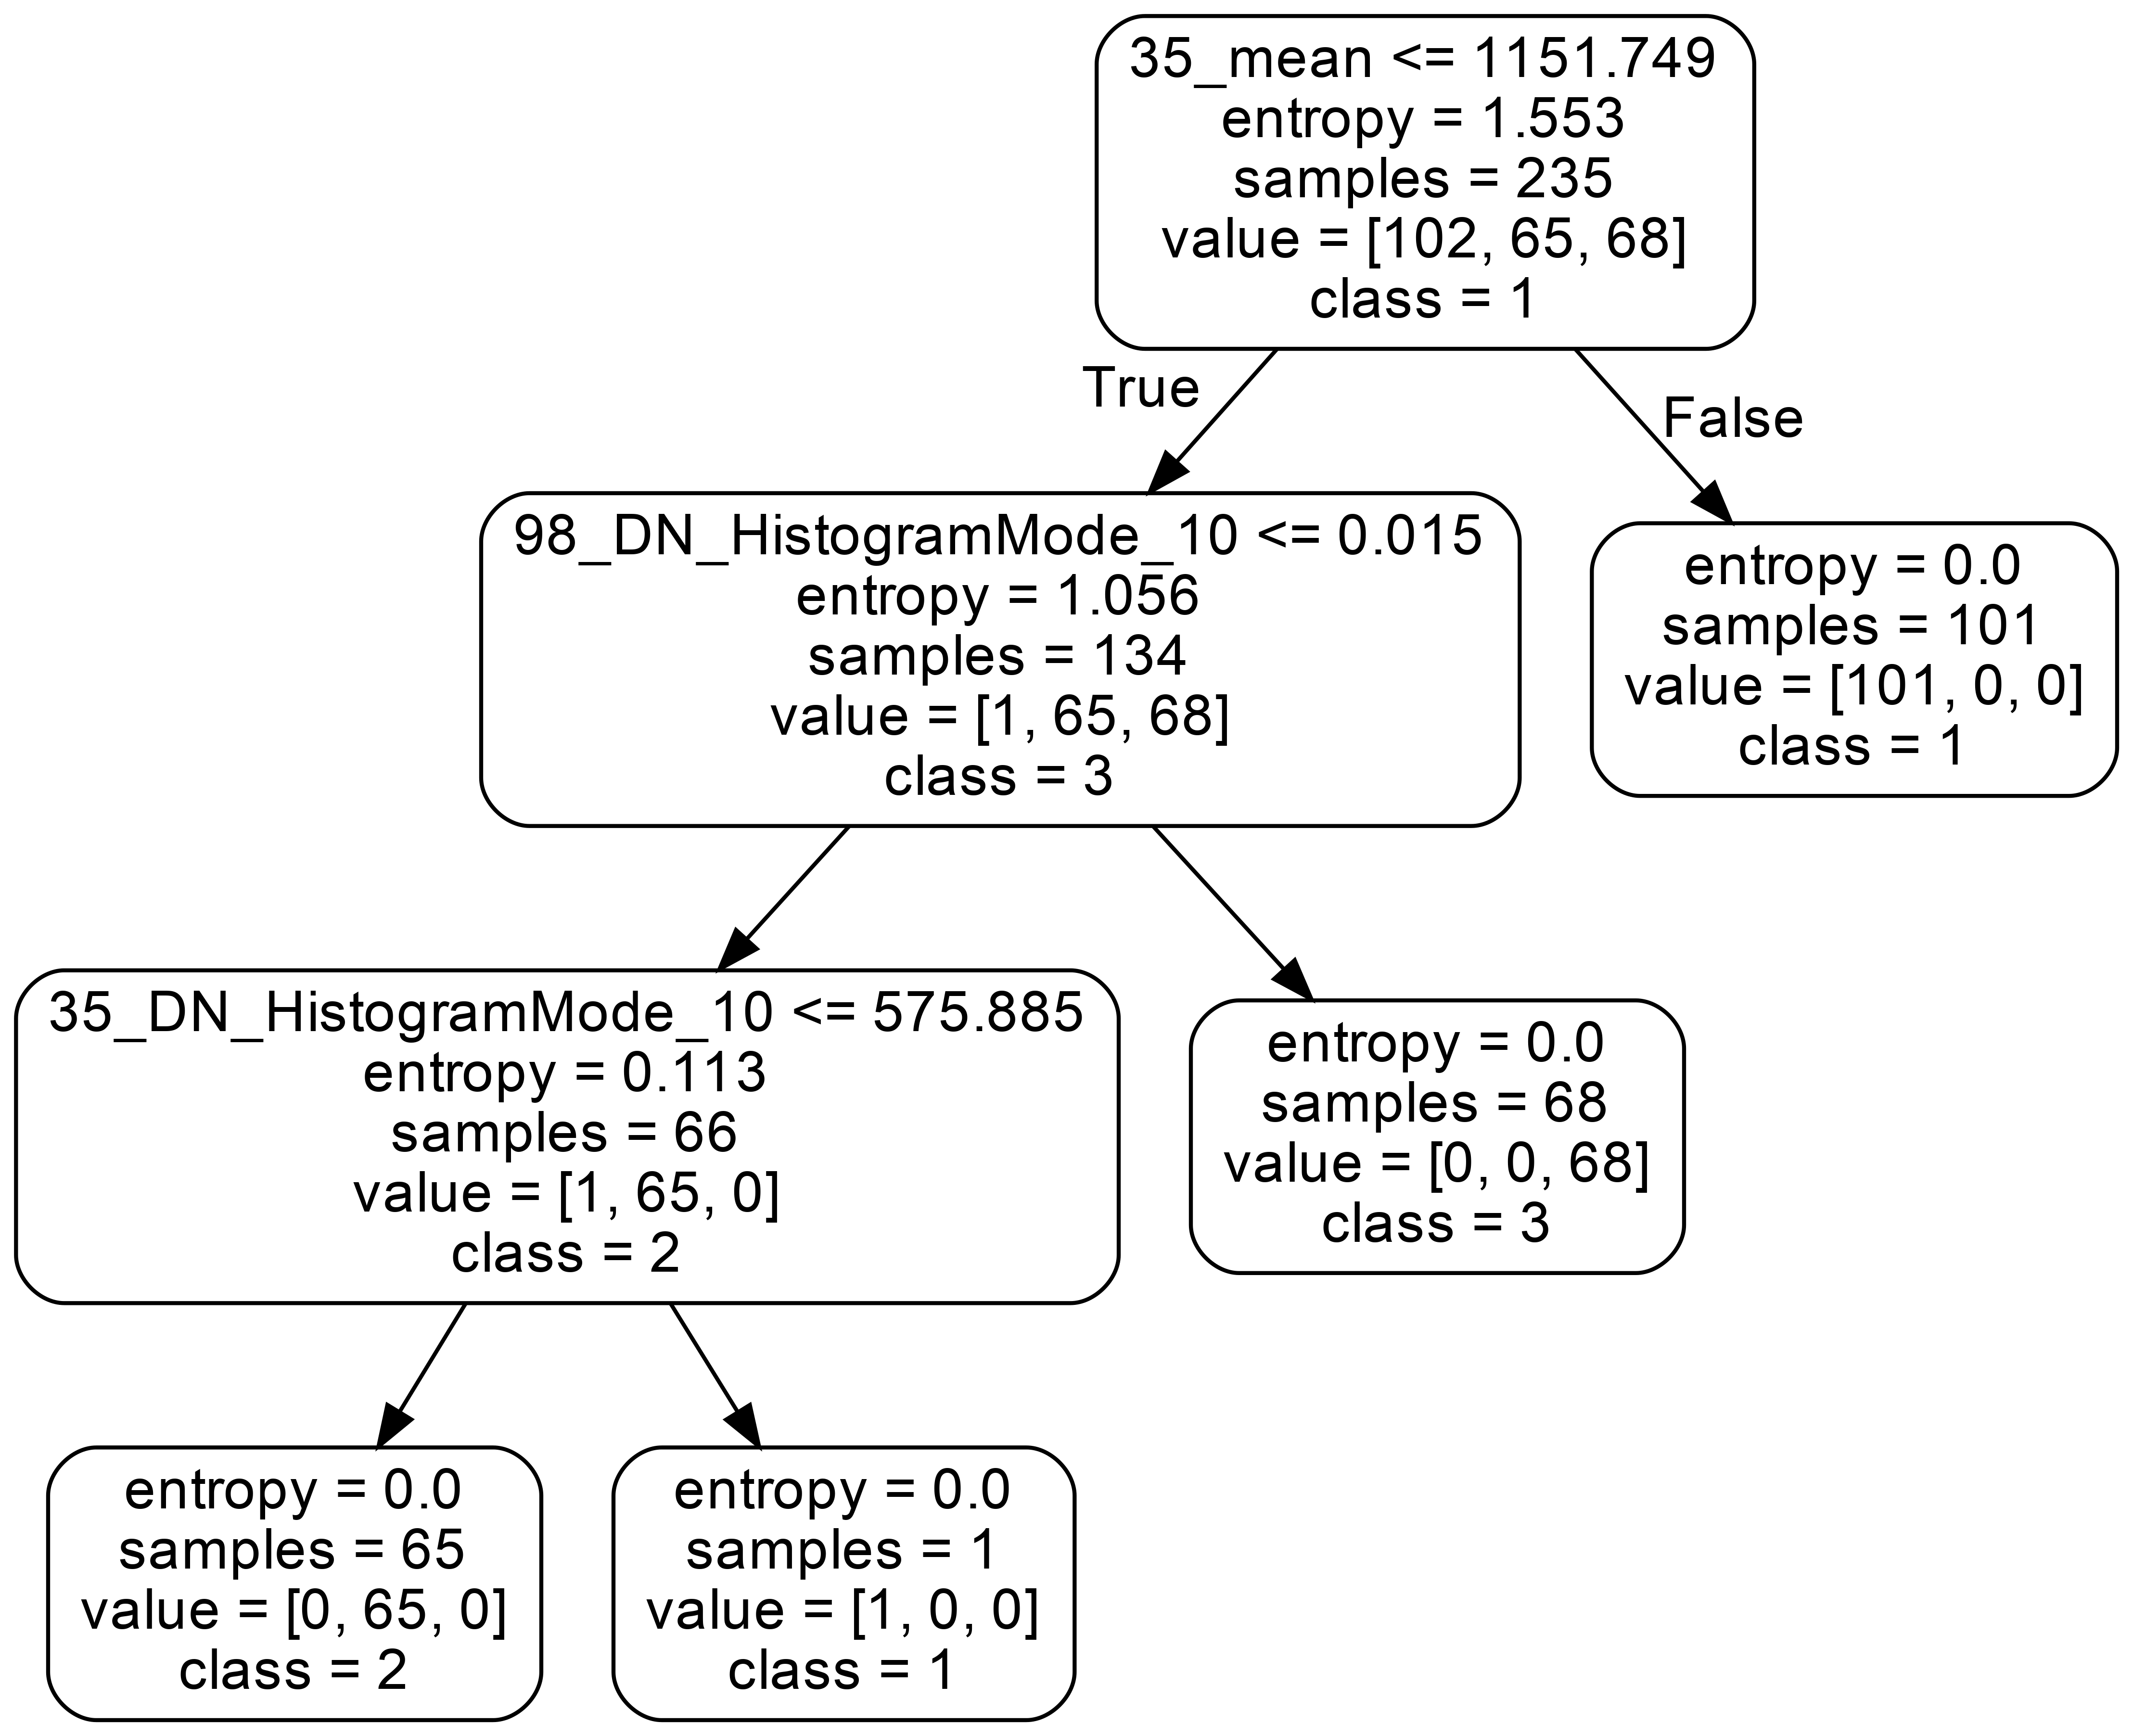

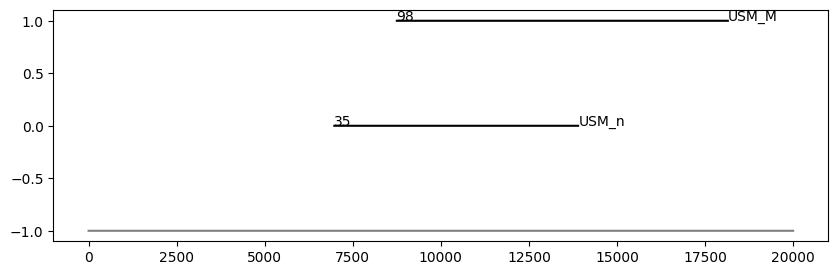

In [33]:
test_size = 0.5
X_train, X_test, y_train, y_test  = train_test_split(X_segments, y_segments, test_size = test_size, random_state=654, stratify = y_segments)
y_pred, name, dims, intervals, atts, feats = analyse_tree(np.swapaxes(X_train, 1, 2), y_train , X_test = np.swapaxes(X_test, 1, 2), y_test = y_test, 
                                                            min_interval = 4000, max_interval = 20000, n_intervals = 100, random_state=45, class_names = ["1", "2", "3"], filename= "Dokumentation_graph_1")
display(Image(name, width=800))

Auf dem Baumdiagramm können wir ablesen, aus welchen Intervallen, welche Features berechnet wurden und wo der Cut-Off gesetzt wurde. Der untere Plot zeigt die Länge und die Position der relevanten Intervalle. Die Beschriftung entspricht der Messgröße, die für dieses Intervall gewählt wurde. Die untere Linie zeigt die Gesamtlänge des Segments. Dadurch wird deutlich, welche Messgrößen, Intervalle und Features besonders relevant sind, was die Interpretation erleichtert.  <br>
In diesem Beispiel wird also in der ersten und dritten Stufe das Interval 35 benutzt und jeweils den Mittelwert und DN_Histogram_Mode_10 zu bestimmen. <br>
Außerdem wird die Einteilung des Trainingssets im Baumdiagramm notiert. Die erste Stufe erkennt schon fast alle Instanzen der Vorschleifen-Klasse basierend auf dem Wert von DN_Histogram_Mode_10 auf Interval 35. Die zweite Stufe unterscheidet fast alle Instanzen der Zahnen und Nachschleifen Klasse basierend auf dem Wert von DN_Histogram_Mode_10 auf Interval 98. 

Vor dem Trainieren eines Entscheidungsbaum werden zufällig Intervalle und Features ausgewählt, deswegen ist es zu empfehlen, mehrere Entscheidungsbäume zu erstellen und die Ergebnisse zu vergleichen. 

Time for predicting: 83.92669486999512
Accuracy: 0.9744680851063829
Confusion matrix:
[[101   0   1]
 [  0  65   0]
 [  2   0  66]]


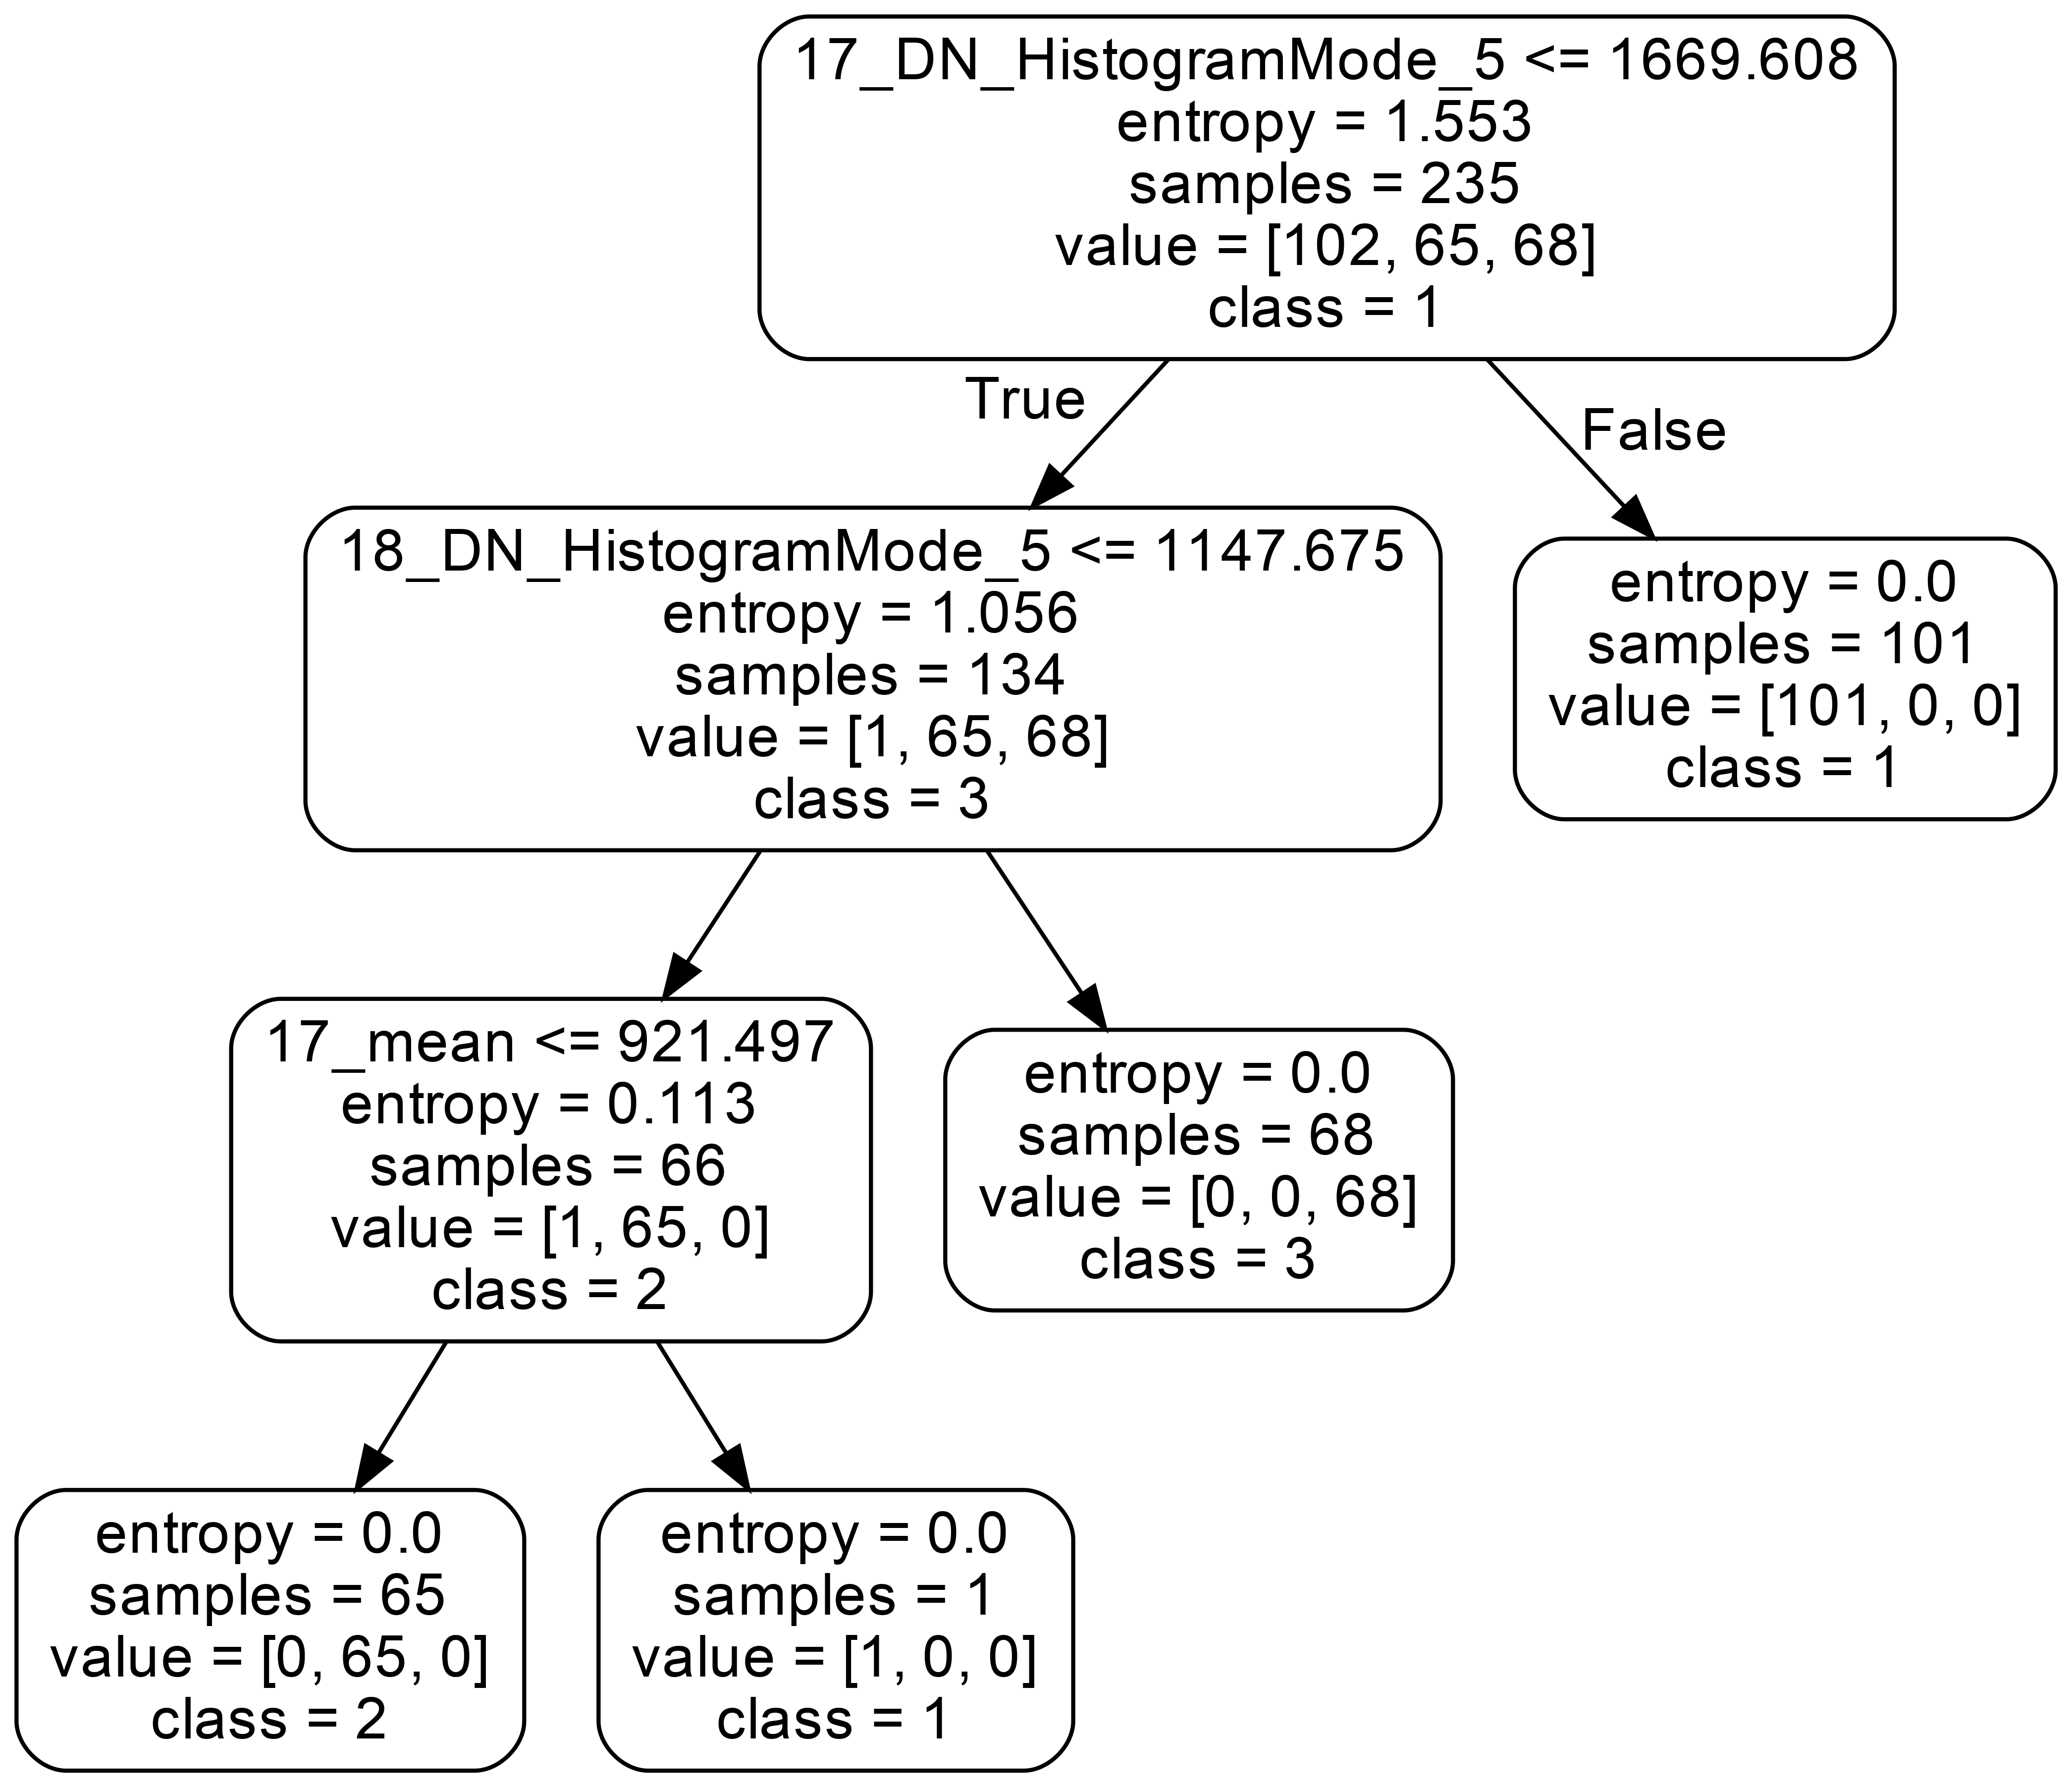

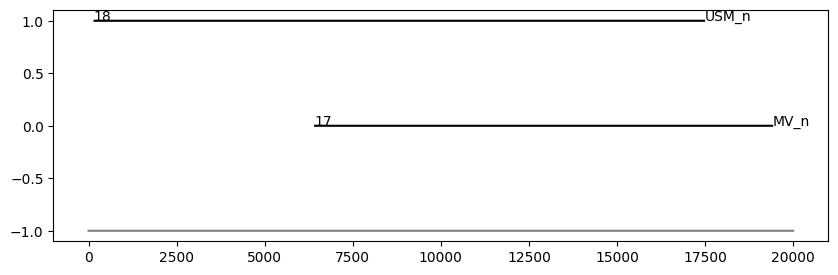

In [89]:
test_size = 0.5
X_train, X_test, y_train, y_test  = train_test_split(X_segments, y_segments, test_size = test_size, random_state=4, stratify = y_segments)
y_pred, name, dims, intervals, atts, feats = analyse_tree(np.swapaxes(X_train, 1, 2), y_train , X_test = np.swapaxes(X_test, 1, 2), y_test = y_test, 
                                                            min_interval = 4000, max_interval = 20000, n_intervals = 100, random_state=45, class_names = ["1", "2", "3"], filename= "Dokumentation_graph_2")
display(Image(name, width=800))

An diesem Beispiel sehen wir, dass auch andere Messgrößen zur genauen Klassifizierung genutzt werden können. Außerdem fällt auf, dass die gewählten Features, den des ersten Baumes sehr ähneln. <br>
CIF ist sehr nützlich, um ein besseres Verständnis für den Zusammenhang zwischen den Messgrößen und den verschiedenen Phasen zu bekommen. Jedoch varriert die Laufzeit je nach gewähltem Feature und Anzahl der Stufen und ist oft höher, als für die anderen Methoden. 

### Euclidean Nearest Neighbor (Euclidean NN)

Diese Methode bestimmt den Datenpunkt der Trainingsdaten (hier ein Segment), der die kleinste euklidische Distanz zu dem zu klassifizierendem Datum hat und wählt dessen Label. <br>
Obwohl das eher unkompliziert ist, funktioniert diese Methode oft vergleichsweise gut. (siehe [3])

In [12]:
def euclidean_fit_predict(X_train, y_train, X_test):
    classifier = KNeighborsClassifier(n_neighbors=1, algorithm= "auto")
    classifier.fit(X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2])), y_train)
    neighbor_inds = classifier.kneighbors(X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2])), return_distance = False)
    st = time.time()
    y_pred = y_train[neighbor_inds].reshape((len(neighbor_inds), ))
    en = time.time()
    return(y_pred, en - st)

In [28]:
output_segs_euclid = test_classifier(euclidean_fit_predict, X_segments, y_segments, N = 5, test_size=0.5)

Acc.:
0.9744680851063829
Confusion matrix:
[[100   0   3]
 [  0  65   0]
 [  0   0  67]]
Acc.:
0.9914893617021276
Confusion matrix:
[[101   0   1]
 [  0  65   0]
 [  0   0  68]]
Acc.:
0.9914893617021276
Confusion matrix:
[[102   0   1]
 [  0  65   0]
 [  0   0  67]]
Acc.:
0.9914893617021276
Confusion matrix:
[[103   0   0]
 [  0  65   0]
 [  1   0  66]]
Acc.:
0.9574468085106383
Confusion matrix:
[[98  0  5]
 [ 0 65  0]
 [ 0  0 67]]

Avg. accuracy: 0.98128 Avg. time: 9.918212890625e-06 
Avg. train size: 235.0 Avg. test size: 235.0


Es ist Wahrscheinlich, dass nicht alle Instanzen des Trainingsdatensatzen gleich relevant für die Entscheidungsfindung sind. <br>
Daher betrachten wir im nächsten Abschnitt eine Möglichkeit zur Optimierung des Trainingsdatensatzes. 

#### Interpretation durch Reduzierung des Trainingsdatensatzes

Wie in [4] beschrieben, entfernen wir möglichst viele Elemente aus dem Trainingsdatensatz unter der Bedinung, dass der ursprünglicher Trainingsdatensatz immernoch richtig klassifizieren wird. <br>
Dieser Vorgang geschieht in zwei Schritten, die "condensing" und "reducing" genannt werden. Das Endergenis kann als Menge von typischen Beispielen für die Segmente bestimmter Klassen interpretiert werden. Außerdem ist die Laufzeit der Klassifikation basierend auf dem optimierten Trainingsdatensatz schneller. Dies ist hier aber eher zweitranging, da bei Euclidean NN die Laufzeit kein Problem darstellt.

In [16]:
def check_condensed(fit_predict, X_train, y_train, condensed_set):
    all_correct =True
    remaining_inds = np.setdiff1d(np.arange(len(X_train)), condensed_set)
    np.random.shuffle(remaining_inds)
    for i in remaining_inds:
        y_pred = fit_predict(X_train[condensed_set, :, :], y_train[condensed_set], X_train[i, :].reshape((1, X_train.shape[1], X_train.shape[2])))[0]
        if y_pred != y_train[i]:
            condensed_set = np.append(condensed_set, i)
            all_correct = False
            break
    return(all_correct, condensed_set)
                
def make_condensed_set(fit_predict, X_train, y_train, initial_size = 5):
    condensed_set = np.random.choice(len(X_train), size=initial_size, replace=False)
    all_correct = False
    while not all_correct:
        all_correct, condensed_set = check_condensed(fit_predict, X_train, y_train, condensed_set)
    print("Removed", len(X_train) - len(condensed_set), "instances.")
    return(X_train[condensed_set, :, :], y_train[condensed_set], condensed_set)

def check_reduced(fit_predict, X_train, y_train, reduced_set):
    all_correct = True
    classifier = KNeighborsClassifier(n_neighbors=1, algorithm= "auto")
    classifier.fit(X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))[reduced_set, :], y_train[reduced_set])
    random_indices = np.setdiff1d(np.arange(len(X_train)), reduced_set)
    np.random.shuffle(random_indices)
    for i in random_indices:
        neighbor_ind = classifier.kneighbors((X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))[i ,:]).reshape(1, -1), return_distance = False)[0]
        prediction = y_train[reduced_set[neighbor_ind]]
        if prediction != y_train[i]:
            all_correct = False
    return(all_correct)

def make_reduced_set(fit_predict, X_train, y_train, condensed_set): # takes a while
    reduced_set = condensed_set
    random_indices = condensed_set
    np.random.shuffle(random_indices)
    for i in random_indices:
        reduced_set = np.setdiff1d(reduced_set, i)
        all_correct = check_reduced(fit_predict, X_train, y_train, reduced_set)
        if not all_correct:
            reduced_set = np.append(reduced_set, i)
    print("Removed", len(condensed_set) - len(reduced_set), "instances.")
    return(X_train[reduced_set, :, :], y_train[reduced_set], reduced_set)

def euclidean_condensed_fit_predict(X_train, y_train, X_test):
    X_train_condensed, y_train_condensed, _ = make_condensed_set(euclidean_fit_predict,X_train, y_train)
    y_pred, time = euclidean_fit_predict(X_train_condensed, y_train_condensed, X_test)
    return(y_pred, time)

def euclidean_reduced_fit_predict(X_train, y_train, X_test):
    X_train_condensed, y_train_condensed, condensed_set = make_condensed_set(euclidean_fit_predict,X_train, y_train)
    X_train_reduced, y_train_reduced, _ = make_reduced_set(euclidean_fit_predict, X_train, y_train, condensed_set)
    y_pred, time = euclidean_fit_predict(X_train_reduced, y_train_reduced, X_test)
    return(y_pred, time)

Zunächst speichern wir eine Aufteilung in Trainings- und Testdaten. 

In [17]:
# get a train/test split
output_segs_euclid = test_classifier(euclidean_fit_predict, X_segments, y_segments, N = 1, get_data = True, test_size=0.5)
train_data = output_segs_euclid[2]
test_data = output_segs_euclid[3]

Acc.:
0.9744680851063829
Confusion matrix:
[[100   0   3]
 [  0  65   0]
 [  0   0  67]]

Avg. accuracy: 0.97447 Avg. time: 1.811981201171875e-05 
Avg. train size: 235.0 Avg. test size: 235.0


Dann optimieren wir den Trainingsdatensatz und vergleichen die erreichte Genauigkeiten auf den Testdaten. <br>

In [18]:
st = time.time()
X_train_condensed, y_train_condensed, condensed_set = make_condensed_set(euclidean_fit_predict,train_data[0][0], train_data[0][1])
X_train_reduced, y_train_reduced, _ = make_reduced_set(euclidean_fit_predict, train_data[0][0], train_data[0][1], condensed_set)
en = time.time()
print("Time needed to condense and reduce:")
print(en-st)
y_pred, t = euclidean_fit_predict(X_train_reduced, y_train_reduced, test_data[0][0])
print("Accuracy:")
print(acc(test_data[0][1], y_pred))
print("Time needed to classify:")
print(t)
print("Confusion Matrix:")
print(confusion_matrix(test_data[0][1], y_pred))

Removed 222 instances.
Removed 5 instances.
Time needed to condense and reduce:
369.5980021953583
Accuracy:
0.9744680851063829
Time needed to classify:
9.059906005859375e-06
Confusion Matrix:
[[102   0   1]
 [  0  65   0]
 [  2   0  65]]


Der Trainingsdatensatz wurde auf acht Instanzen reduziert, die wir im Folgenden zeigen. 

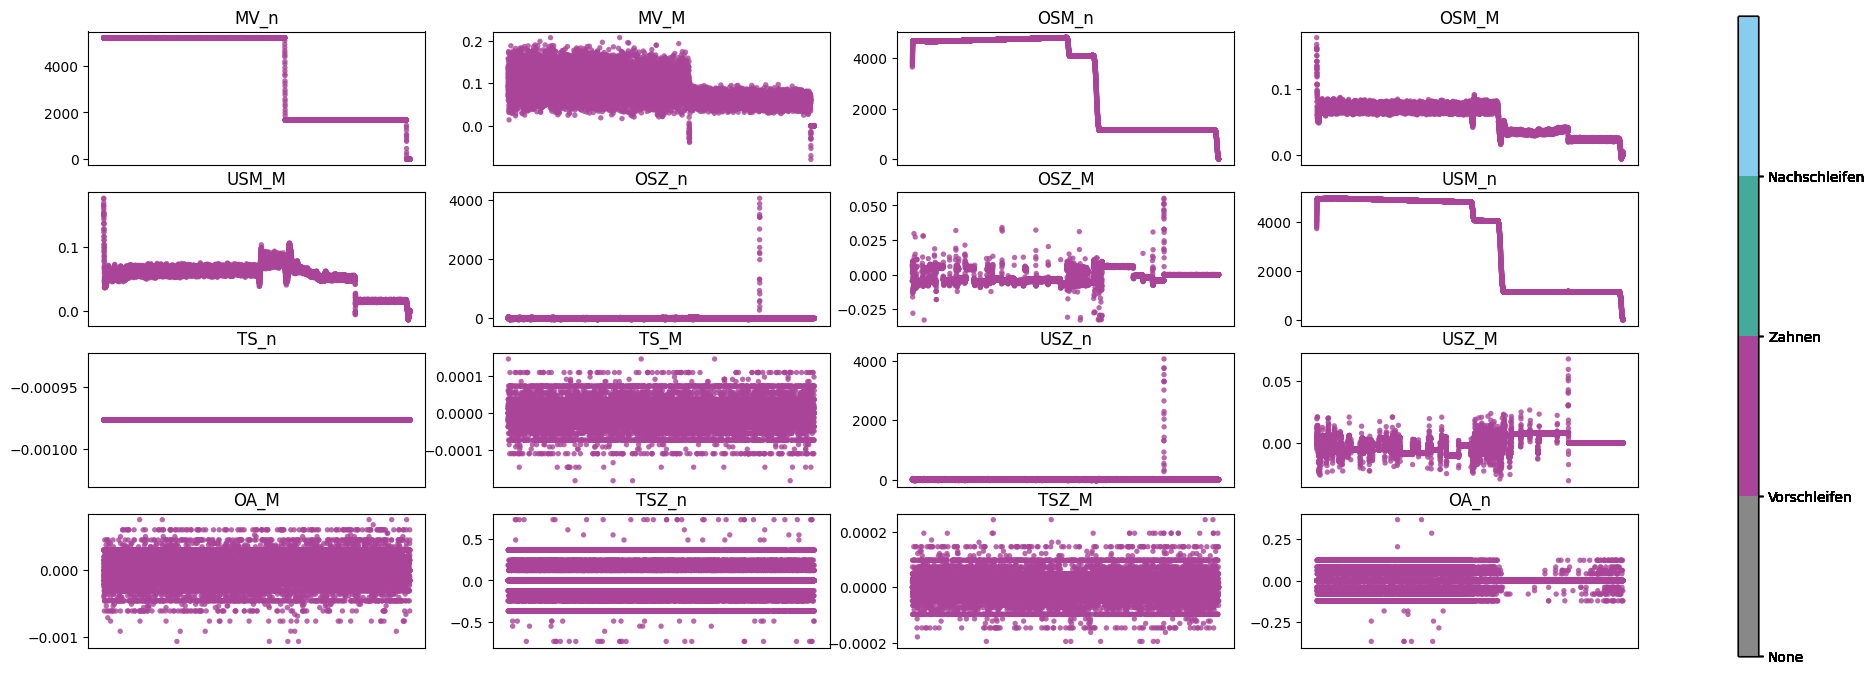

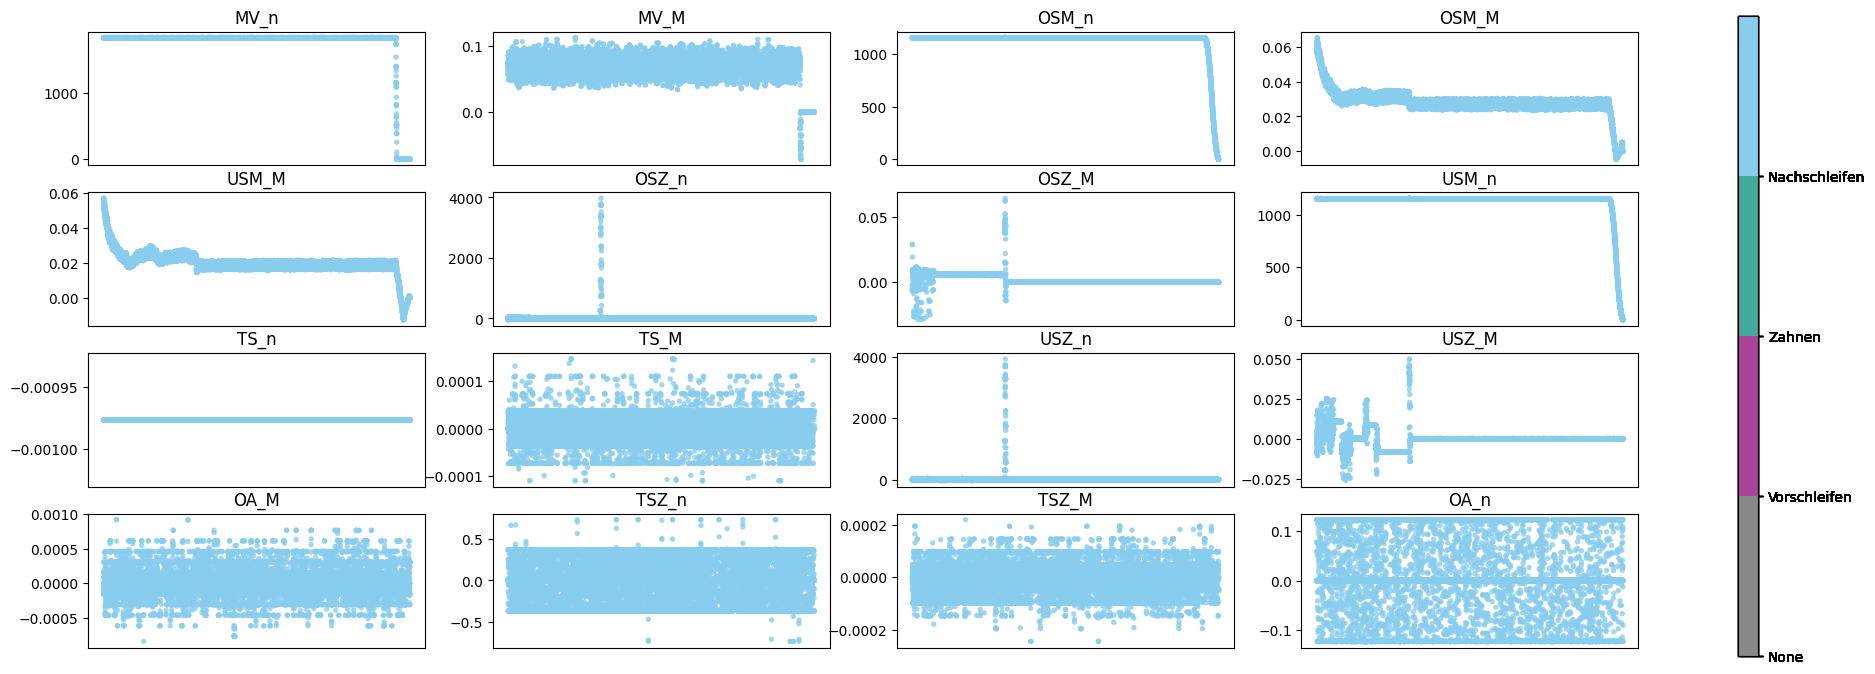

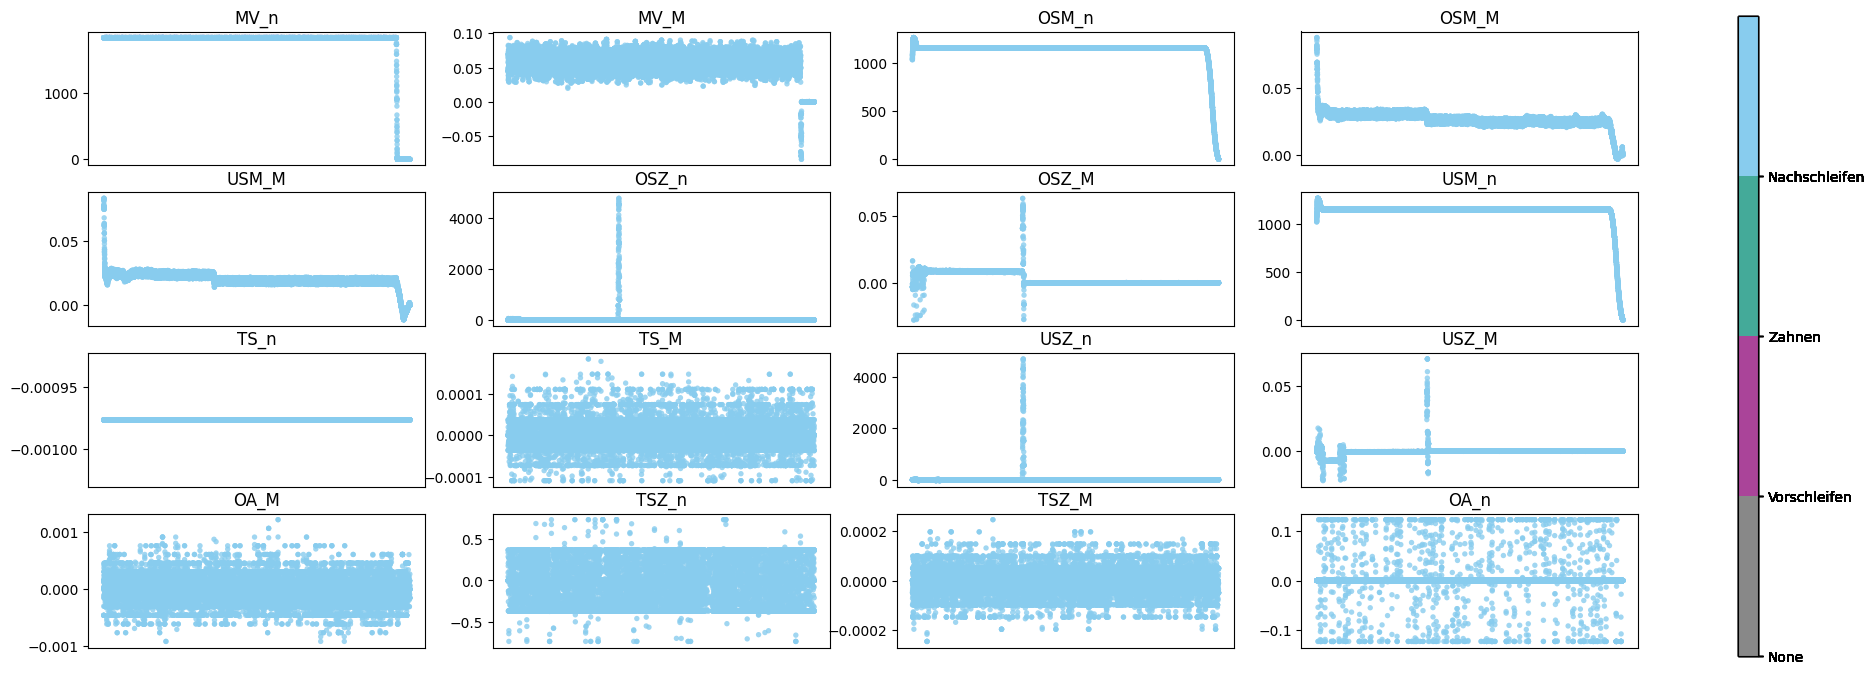

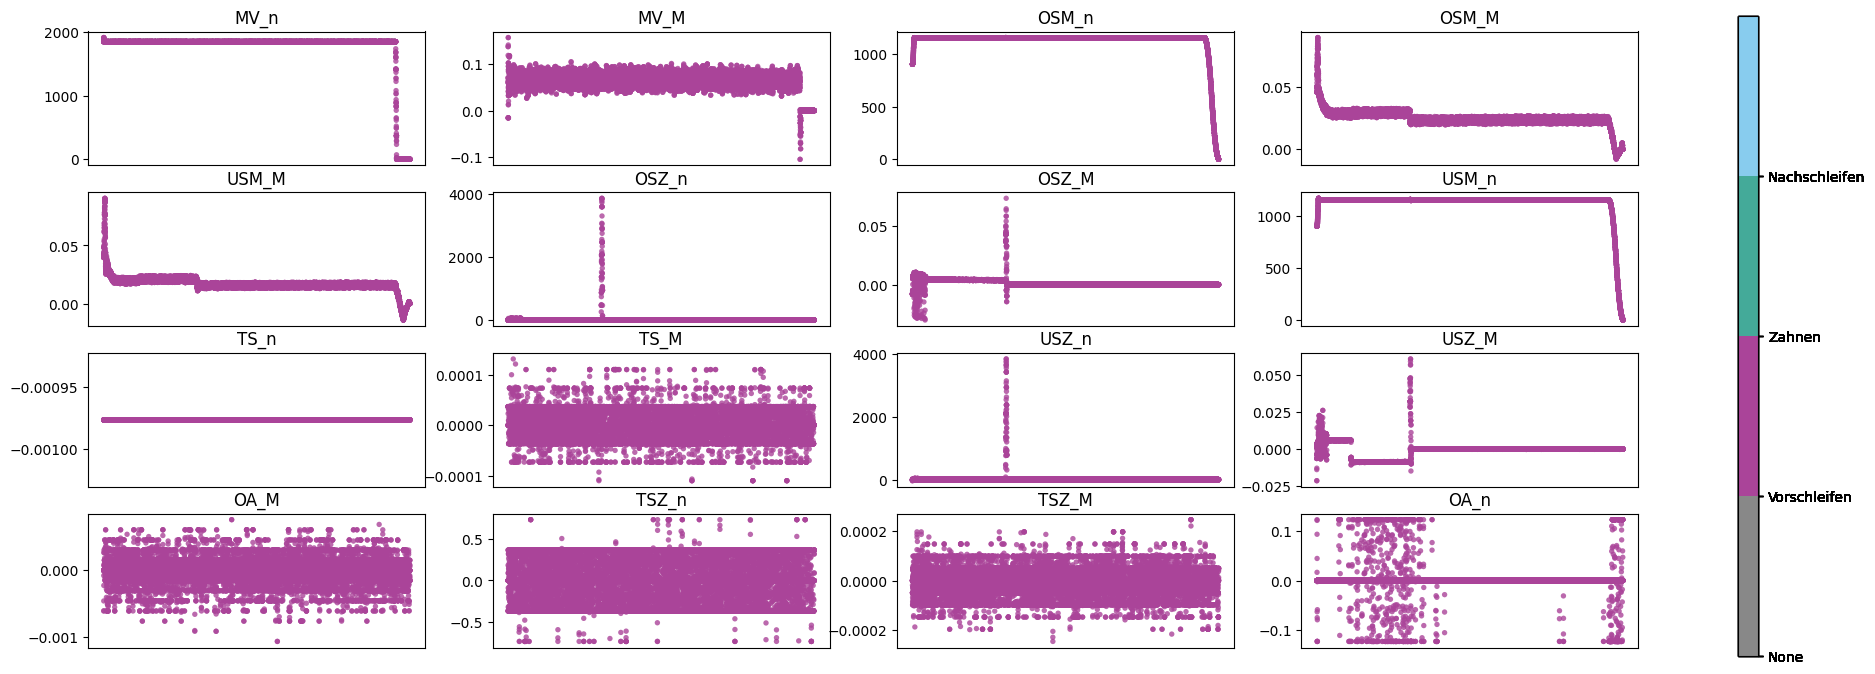

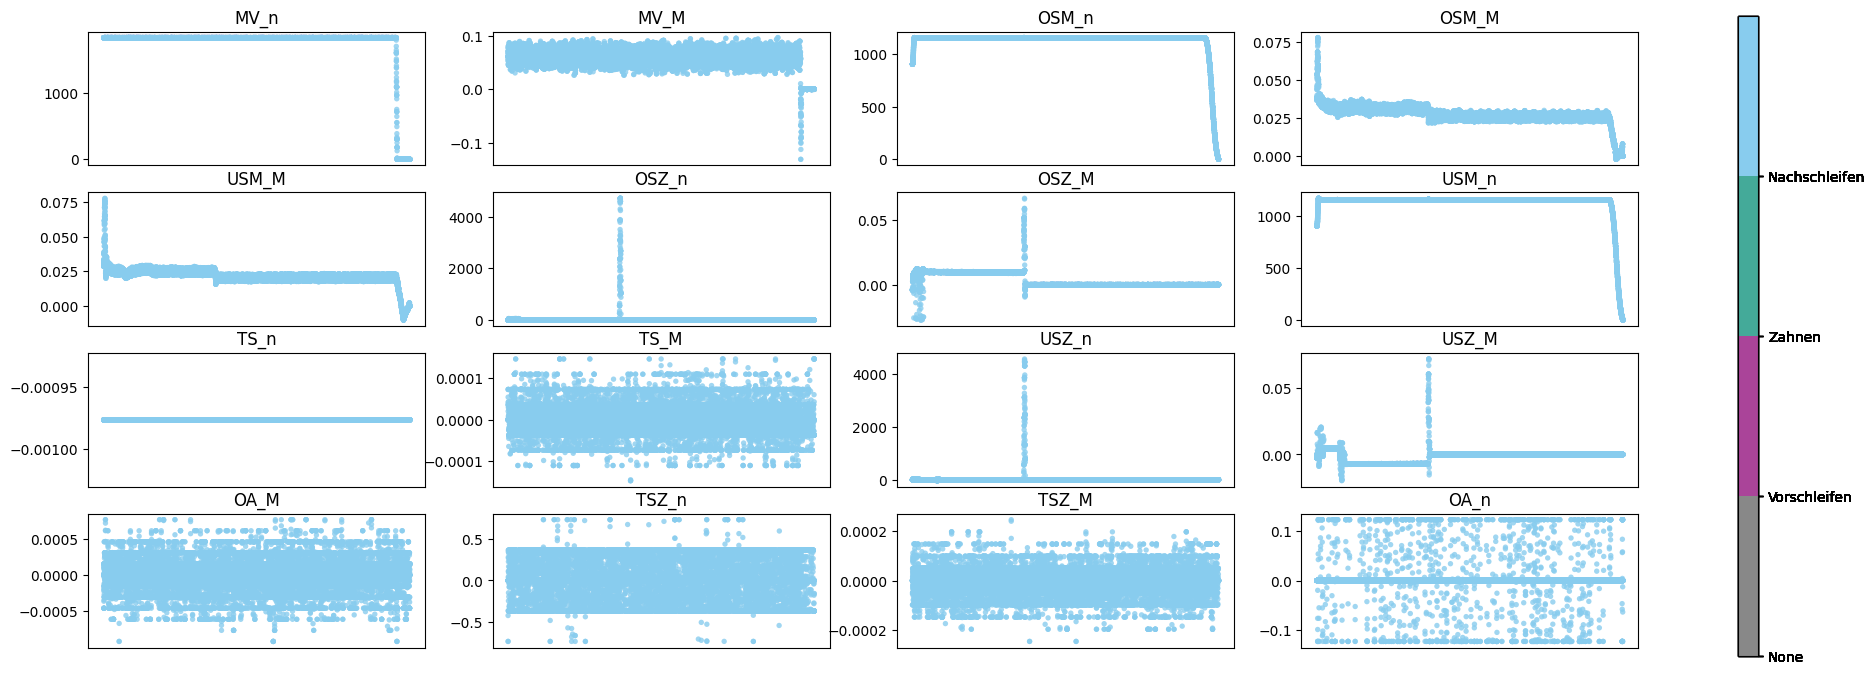

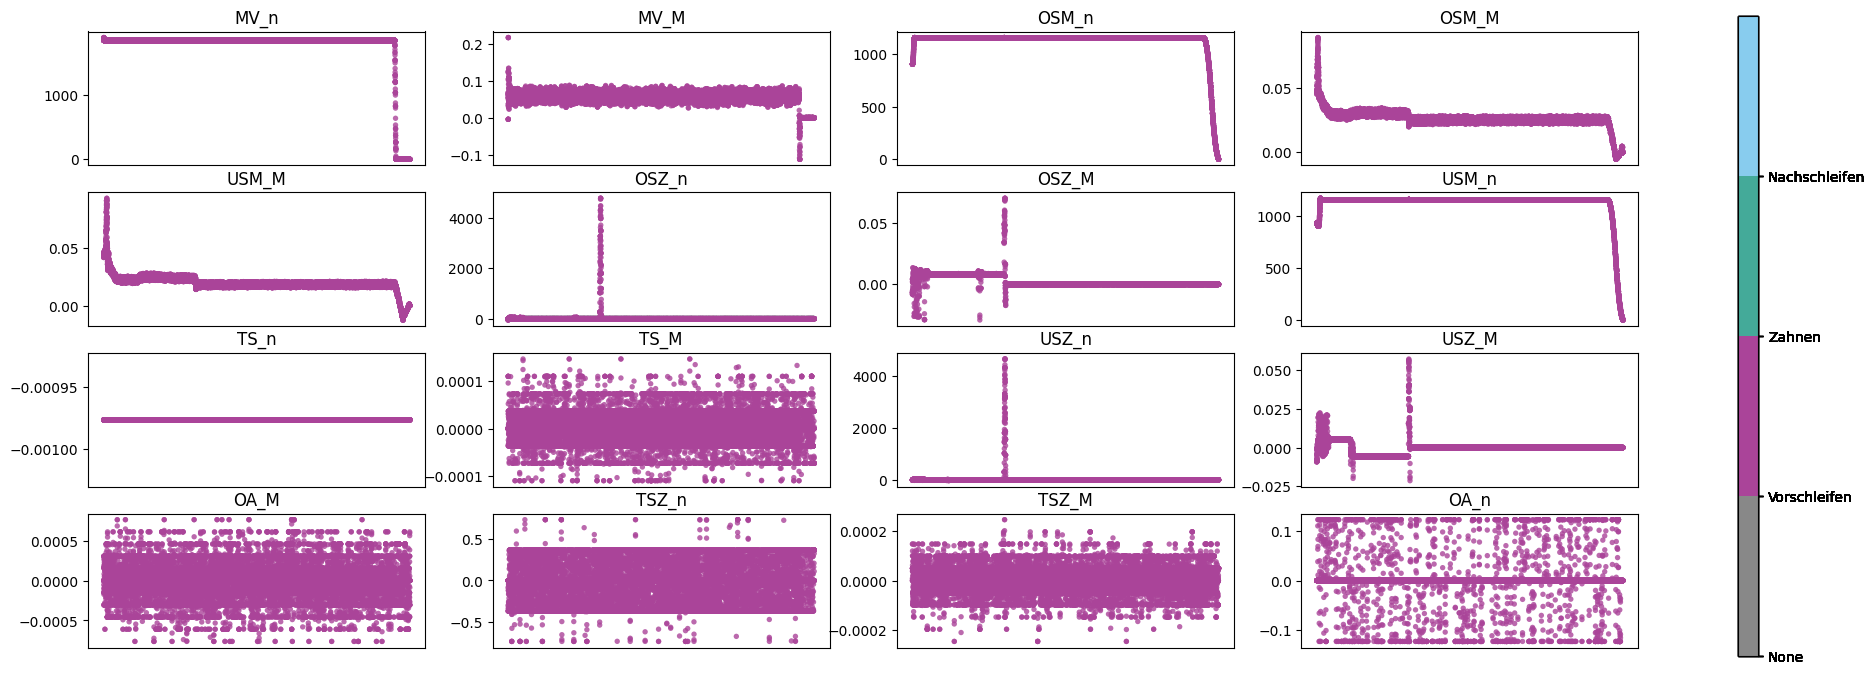

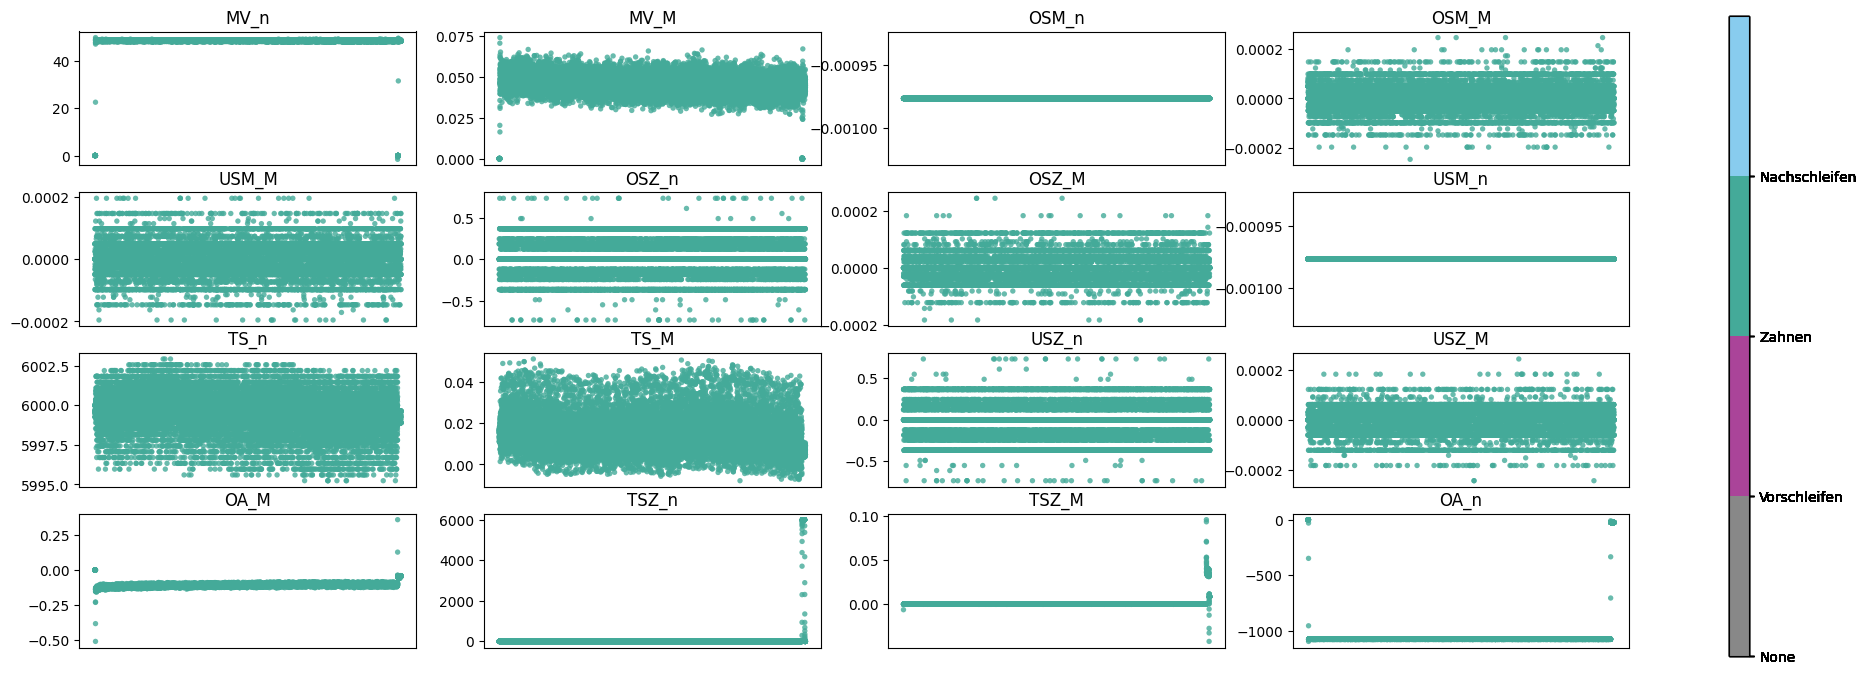

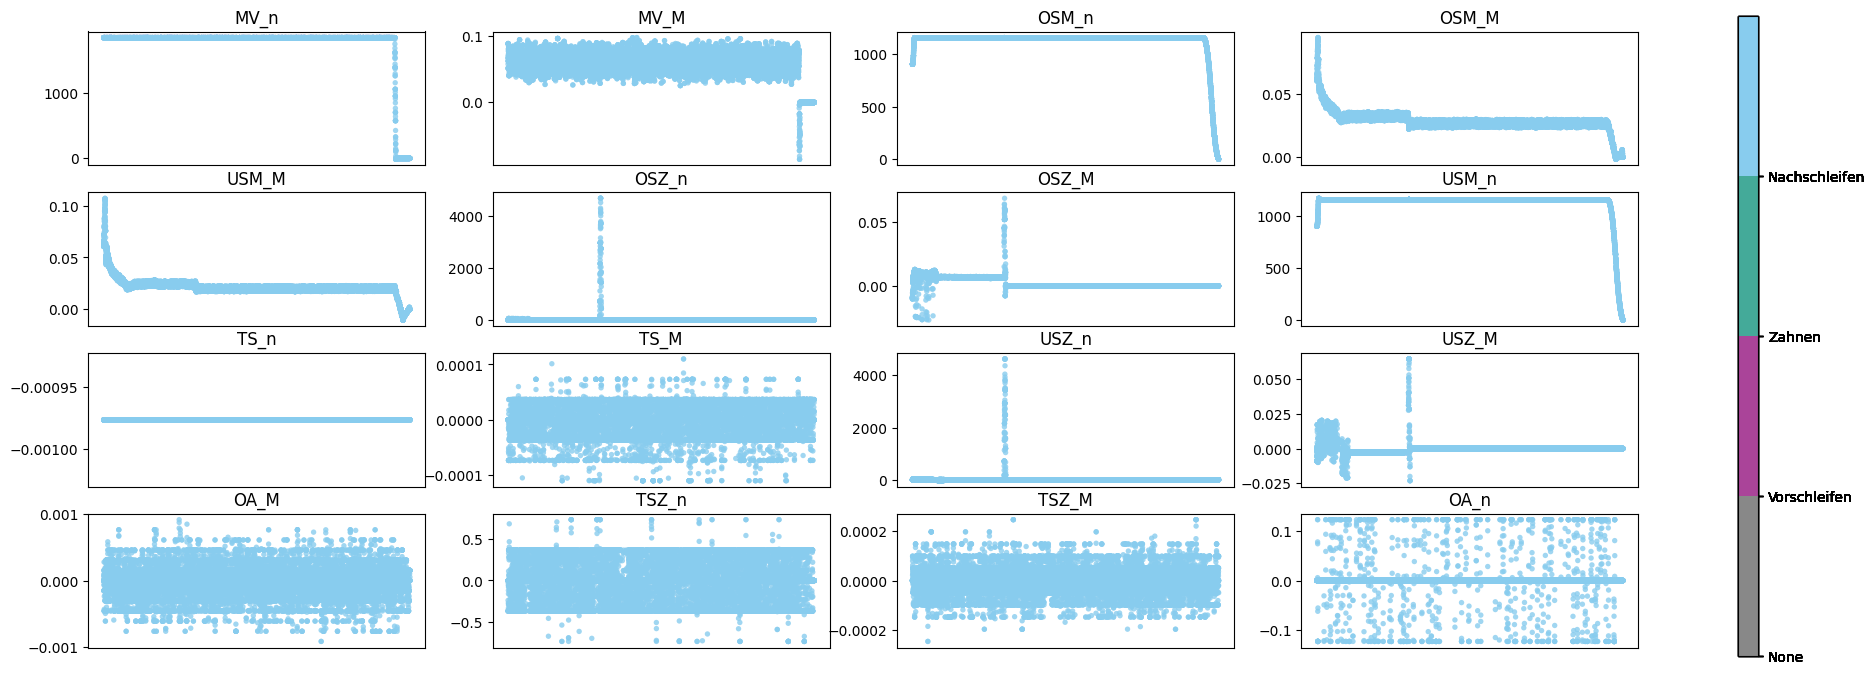

In [19]:
for i in np.arange(len(X_train_reduced)):
    plot_np(X_train_reduced[i, :, :], c = [y_train_reduced[i]], width = 20, height = 2)

Eine Interpretation, die wir den Plots entnehmen können, ist dass sich die Zahnen-Phase stark von Vor- und Nachschleifen unterscheidet, aber sich andererseits manche Vor- und Nachschleifen Segmente sehr ähneln.<br>

### Dependent Dynamic TimeWarping Nearest Neighbor (D_DTW NN)
Diese Methode funktioniert genauso wie Euclidiean NN, nur das der Abstand mit der D_DTW Metrik berechnet wird. Die Definition und Erklärung findet man zum Beispiel in [3].<br>
D_DTW hat den Vorteil, dass die Zeitreihen nicht dieselbe Länge haben müssen. Die D_DTW Metrik scheint sich zunächst gut für unser Anwendungsbeispiel zu eignen, da Prozesse, die einen ähnlichen Verlauf haben, aber gestreckt oder gestaucht wurden eine kleine D_DTW Distanz haben. <br>
Andererseits ist die Berechnung aufwendiger. Daher sollte, wenn beide Methoden funktionieren, Euclidean NN vorgezogen werden. 

In [17]:
D_DTW_classifier_tslearn = tslearn_KNeighborsClassifier(metric = "dtw", n_neighbors = 1)
def D_DTW_fit_predict_tslearn(X_train, y_train, X_test):
    D_DTW_classifier_tslearn.fit(np.swapaxes(X_train, 1, 2), y_train)
    st = time.time()
    y_pred = D_DTW_classifier_tslearn.predict(np.swapaxes(X_test, 1, 2))
    en = time.time()
    return(y_pred, en-st)

In [19]:
output_segs_d_dtw = test_classifier(D_DTW_fit_predict_tslearn, make_sparse_np(np.swapaxes(X_segments_nans[:, :, :-1], 1, 2)), y_segments, N = 5, test_size=0.5)

Acc.:
0.9872340425531915
Confusion matrix:
[[102   0   1]
 [  1  64   0]
 [  0   0  67]]
Acc.:
0.9702127659574468
Confusion matrix:
[[98  1  3]
 [ 0 65  0]
 [ 0  0 68]]
Acc.:
0.9829787234042553
Confusion matrix:
[[100   2   1]
 [  0  65   0]
 [  0   0  67]]
Acc.:
0.9957446808510638
Confusion matrix:
[[103   0   0]
 [  1  64   0]
 [  0   0  67]]
Acc.:
0.9617021276595745
Confusion matrix:
[[98  1  4]
 [ 0 65  0]
 [ 0  0 67]]

Avg. accuracy: 0.97957 Avg. time: 5.749243640899659 
Avg. train size: 235.0 Avg. test size: 235.0


Wir beobachten keine Verbesserung, aber eine deutlich gestiegene Laufzeit im Vergleich zu Euclidean NN, obwohl hier nocheinmal Zeitpunkte zusammengefasst wurden.  <br>
Genauso wie für Euclidean NN können wir auch hier den Trainingsdatensatz optimieren, was die Laufzeit deutlich verbessern würde.  

In [20]:
def D_DTW_condensed_fit_predict(X_train, y_train, X_test):
    X_train_condensed, y_train_condensed, _ = make_condensed_set(D_DTW_fit_predict_tslearn,X_train, y_train)
    y_pred, time = D_DTW_fit_predict_tslearn(X_train_condensed, y_train_condensed, X_test)
    return(y_pred, time)

def D_DTW_reduced_fit_predict(X_train, y_train, X_test):
    X_train_condensed, y_train_condensed, condensed_set = make_condensed_set(D_DTW_fit_predict_tslearn,X_train, y_train)
    X_train_reduced, y_train_reduced, _ = make_reduced_set(D_DTW_fit_predict_tslearn, X_train, y_train, condensed_set)
    y_pred, time = D_DTW_fit_predict_tslearn(X_train_reduced, y_train_reduced, X_test)
    return(y_pred, time)

### RandOm Convolutional KErnel Transform (ROCKET)
ROCKET berechnet neue Features mithilfe zufällig gewählter Faltungskerne und klassifiziert die so entstandenen Daten mit sklearn's [RidgeClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html).<br>
Für mehr Details siehe [5]. Insbesondere wurde beobachtet, dass ROCKET in vielen Beispielen eine gute Genauigkeit mit einer geringen Laufzeit erreichen konnte. ROCKET basiert auf einem ähnlichem Konzept wie ein Convolutional Neural Network, aber hat den Vorteil, dass oft auch ein kleiner Trainingsdatensatz zu guten Ergebnissen führt. 

In [24]:
rocket_classifier = RocketClassifier(num_kernels= 500, n_jobs = -1)

def rocket_fit_predict(X_train, y_train, X_test):
    rocket_classifier.fit(X_train, y_train)
    st = time.time()
    y_pred = rocket_classifier.predict(X_test)
    en = time.time()
    return(y_pred, en - st)

In [45]:
output_segs_rocket = test_classifier(rocket_fit_predict, make_sparse_np(np.swapaxes(X_segments[:, :, :-1], 1, 2)), y_segments, N = 5, test_size=0.5)

Acc.:
0.9829787234042553
Confusion matrix:
[[102   0   1]
 [  0  65   0]
 [  1   0  66]]
Acc.:
0.9829787234042553
Confusion matrix:
[[100   0   2]
 [  0  65   0]
 [  0   0  68]]
Acc.:
0.9659574468085106
Confusion matrix:
[[100   0   3]
 [  0  65   0]
 [  1   0  66]]
Acc.:
1.0
Confusion matrix:
[[103   0   0]
 [  0  65   0]
 [  0   0  67]]
Acc.:
0.9744680851063829
Confusion matrix:
[[101   0   2]
 [  0  65   0]
 [  1   0  66]]

Avg. accuracy: 0.98128 Avg. time: 2.548342752456665 
Avg. train size: 235.0 Avg. test size: 235.0


Die Laufzeit und Genauigkeit von ROCKET haben in diesem Beispiel keinen Vorteil im Vergleich zu Euclidean NN . 

## Zusammenfügen von Fenstern zu Segmenten

In diesem Abschnitt klassifizieren wir die extrahierten Fenster der Länge 20000 mit Increment 5000, wie in dem Abschnitt über die Datentypen beschrieben. Zur Klassifizierung benutzen wir Euclidean NN.  

In [53]:
def find_stamps_from_pred(y_pred, window_length = 20000 ,increment = 5000, min_length=15000):
    """
    y_pred: np array of predicted window labels
    window_length, increment : as in get_windows
    min_length: minimum length of a class segment
    Returns the predicted timepoints at which one segment ends and the next segment begins and an array of the corresponding segment labels. 
    """
    pred_stamps = []
    y_stamps = []
    # randomly assign overlap to one of the overlapping classes
    y_pred[y_pred ==3] = np.random.choice([1, 2], size = np.sum(y_pred == 3)) 

    # summarize consecutive windows of the same class
    for i in np.arange(len(y_pred) - 1):
        if y_pred[i] != y_pred[i+1]:
                if len(pred_stamps) > 0:
                    pred_stamps.append([pred_stamps[-1][1], i*increment + window_length])  
                else:
                    pred_stamps.append([0, i*increment + window_length])  
                y_stamps.append(y_pred[i])  

    # filter by min_length
    pred_len = len(pred_stamps)
    i = 0
    while i < pred_len:
        if pred_stamps[i][1] - pred_stamps[i][0] < min_length:
            if i > 0:
                pred_stamps[i-1][1] = pred_stamps[i][1]
            else:
                pred_stamps[i+1][0] = 0
            del pred_stamps[i] 
            del y_stamps[i] 
            pred_len -= 1
        else:
            i+=1
            
    # summarize consecutive windows once again 
    pred_len = len(pred_stamps)
    i = 0
    while i < pred_len -1:
        if y_stamps[i] == y_stamps[i+1]:
            pred_stamps[i][1] = pred_stamps[i+1][1]
            del pred_stamps[i+1] 
            del y_stamps[i+1] 
            pred_len -= 1
        else:
            i += 1            
    return(pred_stamps, y_stamps)

def make_colormap_classes_simple(fig):
    """ 
    Helper function for coloring the different classes
    """
    RR = [136, 170, 68]
    GG = [136, 68, 170]
    BB = [136, 153, 153]
    colors = np.c_[RR, GG, BB] / 255
    my_cmap = mpl.colors.LinearSegmentedColormap.from_list('RADAR', colors)
    VariableLimits = np.array([0, 1, 2])
    norm = mpl.colors.BoundaryNorm(np.append(VariableLimits, 1000), ncolors=256)
    ax_leg = fig.add_axes([0.95, 0.1, 0.01, 0.8])
    cb = mpl.colorbar.ColorbarBase(ax_leg, cmap=my_cmap,ticks=VariableLimits, norm = norm, format='%1i')
    cb.set_ticklabels(["None", "Schleifen", "Zahnen"])
    return(my_cmap, norm)

def plot_timestamps(raw_data, timestamps, chans_ind = 1, step = 1000, color_map = make_colormap_classes ):
    """
    raw_data: pd dataframe like data_pd in get_windows, the data from which the windows were extracted
    timestamps: array of timepoints at which one segment ends and the next segment begins
    chans_ind: index w.r.t. chans of the dimension to plot
    step: int, which points to plot
    color_map: function handle, either make_colormap_classes or make_colormap_classes_simple
    """
    fig, ax = plt.subplots(figsize= (45, 5))
    my_cmap, norm = make_colormap_classes_simple(fig)
    fig.suptitle(chans[chans_ind])
    ax.scatter(x = np.arange(len(raw_data), step = step), y = raw_data[chans[chans_ind]][::step], c = make_y_simple(raw_data["which_class"][::step].to_numpy()),cmap = my_cmap, norm = norm, s = 20 ,alpha = 0.8, edgecolors = "None")
    ax.vlines([i[0] for i in timestamps], ymin =min(raw_data[chans[chans_ind]][::step]) , ymax = max(raw_data[chans[chans_ind]][::step]), color = "#fcb001", linewidth = 2, alpha = 0.8)
    return(fig, ax)


def compare_timestamps(raw_data, timestamps, pred_timestamps,y_stamps, chans_ind = 1, step = 1000):
    """
    raw_data: pd dataframe like data_pd in get_windows, the data from which the windows were extracted
    timestamps: array of timepoints at which one segment ends and the next segment begins
    pred_timestamps: array of predicted timepoints
    chans_inds: index w.r.t. chans of the dimension to plot
    step: int, which points to plot

    The orange lines correspond to the true timepoints and the dashed blue lines to the predicted timepoints. 
    """
    fig, ax = plot_timestamps(raw_data, timestamps, chans_ind, step, color_map= make_colormap_classes_simple)
    my_cmap, norm = make_colormap_classes_simple(fig)
    ax.vlines([i[0] for i in pred_timestamps], ymin =min(raw_data[chans[chans_ind]][::step]) , ymax = max(raw_data[chans[chans_ind]][::step]),  color = "#056eee",  linestyles="dotted", alpha = 0.8)
    for i in np.arange(len(pred_timestamps)-1):
        ax.hlines(min(raw_data[chans[chans_ind]][::step])*1.15, xmin = pred_timestamps[i][0], xmax=pred_timestamps[i][1], color = my_cmap(norm(y_stamps[i])), linewidth = 5)

In [79]:
output_segs_euclid = test_classifier(euclidean_fit_predict,make_sparse_np(np.swapaxes(X_windows[:, :, :-1], 1, 2)), y_windows, N = 5, get_data = False, test_size=0.75)

Acc.:
0.9042535985767427
Confusion matrix:
[[1125    1    0    3    0    0]
 [   0 1844    0  120    2    1]
 [   0    0 1175    0   22    1]
 [   3  107    0  559    0    2]
 [   0    5    9    0  701    0]
 [   0    0    0    7    0  496]]
Acc.:
0.9129872230308912
Confusion matrix:
[[1128    0    0    1    0    0]
 [   0 1840    0  125    0    2]
 [   0    0 1187    0    9    2]
 [   3   93    0  575    0    0]
 [   0    3   14    1  697    0]
 [   0    0    1    4    0  498]]
Acc.:
0.9120168203137635
Confusion matrix:
[[1129    1    0    0    0    0]
 [   2 1810    0  147    8    0]
 [   0    0 1193    0    5    0]
 [   6   60    0  600    0    5]
 [   0    2   16    0  697    0]
 [   0    0    1    6    0  495]]
Acc.:
0.903444929645803
Confusion matrix:
[[1117    2    0   10    0    0]
 [   0 1886    0   79    2    0]
 [   0    0 1190    0    8    0]
 [   5  126    0  538    0    2]
 [   0    7   16    0  692    0]
 [   0    2    1   15    0  485]]
Acc.:
0.8989163836325409
Confusio

Die Genauigkeit ist auch in diesem komplizierteren Szenario hoch.<br>
Jedoch werden Vor- und Nachschleifen nicht immer richtig unterschieden. Basierend auf dem optimierten Trainingsset in dem Abschnitt zu Euclidean NN war dies allerdings zu erwarten. Daher zeigen wir das Zusammenfügen von Fenstern zu Segmenten unter der einfacheren Klasseneinteilung, wie in dem Abschnitt zu den Datentypen beschrieben. <br>
In diesem Fall erreichen wir eine fast perfekte Einteilung der Testdaten. 

In [76]:
y_pred_continuous, t = euclidean_fit_predict(make_sparse_np(np.swapaxes(X_windows[:, :, :-1], 1, 2)), y_windows_simple, make_sparse_np(np.swapaxes(X_continuous_windows[:, :, :-1], 1, 2)))

In [77]:
print("Confusion Matrix:")
print(confusion_matrix(y_continuous_windows_simple, y_pred_continuous))
print("Accuracy:")
acc(y_pred_continuous, y_continuous_windows_simple)

Confusion Matrix:
[[1436    1    0    0]
 [   0  159    0    0]
 [   0    0   64    0]
 [   0    0    0   66]]
Accuracy:


0.9994206257242179

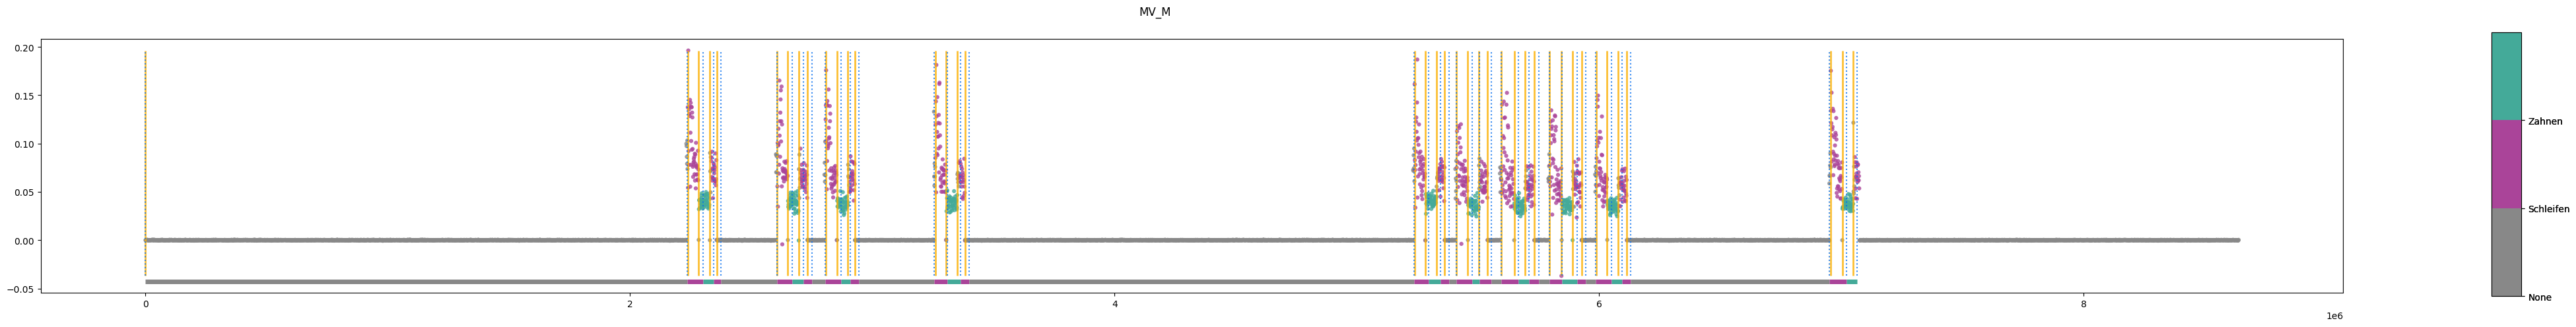

In [85]:
pred_stamps, y_stamps = find_stamps_from_pred(y_pred_continuous)
compare_timestamps(raw_data_pd, timestamps, pred_stamps, y_stamps)
plt.savefig("imgs/compare_timestamps.png" )

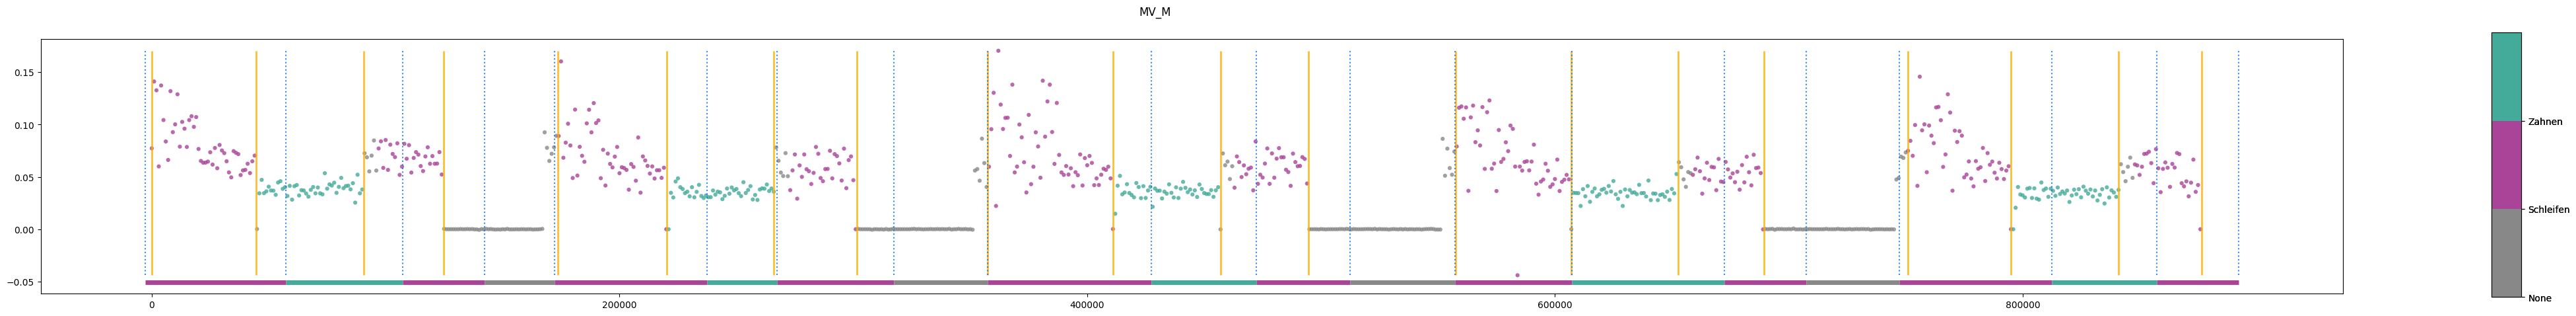

In [88]:
compare_timestamps(raw_data_pd.iloc[timestamps[17][0]:timestamps[36][0], :], [ i - timestamps[17][0] for i in timestamps[17:37]], 
                    [ i - timestamps[17][0] for i in pred_stamps[17:37]], y_stamps[17:37])
plt.savefig("imgs/compare_timestamps_zoomed.png" )

Basierend auf dieser Klassifizierung bestimmt die Funktion `find_stamps_from_pred` Start- und Endpunkte von Segmenten. <br>
In den oberen Plots zeigen die orangene Linie, die wahren Start- und Endpunkte und die blauen, gepunkteten die Erstellten. 
Die untere Linie zeigt die Klasseneinteilung der Segmente.

## Fazit

In dieser Anwendung ist zur sicheren Unterscheidungs der Phasen die Unterteilung in Segmente nötig und den Fenstern vorzuziehen. <br>
Zur Klassifizierung der Segmente reichen allerdings schon einfache Methoden wie Euclidean NN aus. Durch das Optimieren des Trainingsset haben wir für Euclidean NN eine Möglichkeit zur Interpretation. <br>
CIF kann dem Benutzer explizite Kriterien zur Unterscheidung der verschiedenen Phasen liefern und erreicht damit die Beste Interpretierbarkeit. 

## References

1. Matthew Middlehurst and James Large and Anthony Bagnall. "The Canonical Interval Forest (CIF) Classifier for Time Series Classification." IEEE International Conference on Big Data 2020 (2020)

2. Lubba, C.H., Sethi, S.S., Knaute, P. et al. "catch22: CAnonical Time-series CHaracteristics." Data Min Knowl Disc 33, 1821–1852 (2019)

3. Ruiz, Alejandro & Flynn, Michael & Large, James & Middlehurst, Matthew & Bagnall, Anthony. "The great multivariate time series classification bake off: a review and experimental evaluation of recent algorithmic advances." Data Mining and Knowledge Discovery (2021)

4. Gates, Geoffrey W.. “The reduced nearest neighbor rule (Corresp.).” IEEE Trans. Inf. Theory 18 (1972)

5. Dempster, Angus & Petitjean, François & Webb, Geoffrey. "ROCKET: Exceptionally fast and accurate time series classification using random convolutional kernels." (2019)